# Energy and Buildings Paper V4

In [115]:
import pandas as pd
import requests
import pvlib
import matplotlib.pyplot as plt  # for visualization
import math
from datetime import datetime
from ast import literal_eval

In [47]:
#variables - MAKE SURE THESE ARE IDENTICAL TO WHAT WAS USED IN THE MODEL
myNetworks = ['bowling green','long island city','sunnyside','crown heights','grasslands','fresh kills','williamsburg','northeast bronx','ridgewood']

#these are the columns with lists in them
strToList = ['annualPVkWhDC_degraded','annualPVkWhAC_degraded','avoidedGridCosts','maxAutoParticipationMonthlyW_C','maxAutoParticipationMonthlyW_D','maxAutoParticipationW_C','maxAutoParticipationW_D','drIncMonthly_C','drIncMonthly_D','drIncAnnual_C','drIncAnnual_D','drPerformanceIncome','annualIncome']

# Read Data

## Read Model Results

In [48]:
results_df = pd.read_csv('results/results_df_1707138690.csv')

#drop the index if it was saved in the  file
results_df = results_df.drop(columns='Unnamed: 0')
results_df.head()

,network,eventStart,az,pvW,batWh,batWhAC,effEff,gridChargeTime,dischargeRateW,capex,...,minDRkWperf,annualIncome,LCOSS,realRoi,Cycles,lifespan,workingLife,profitableYears,incomeAfterRoi,iarSplit
0,bowling green,11,110,40,288.0,240.558917,0.835274,2.0,57.6,512.659713,...,0.312609,"[10.768928186546251, 10.684480331876076, 10.59...",0.031259,52.089332,3000,8.219178,8.219178,0.0,0.0,0.0
1,bowling green,11,110,50,288.0,240.558917,0.835274,2.0,57.6,524.635963,...,0.306496,"[13.447050371702087, 13.39253286911642, 13.335...",0.031429,41.117353,3000,8.219178,8.219178,0.0,0.0,0.0
2,bowling green,11,110,60,288.0,240.558917,0.835274,2.0,57.6,536.612213,...,0.300383,"[16.125064390756886, 16.10048016363939, 16.074...",0.031598,34.259325,3000,8.219178,8.219178,0.0,0.0,0.0
3,bowling green,11,110,70,288.0,240.558917,0.835274,2.0,57.6,548.588463,...,0.294269,"[18.802893024710247, 18.80824843437299, 18.812...",0.031766,29.566896,3000,8.219178,8.219178,0.0,0.0,0.0
4,bowling green,11,110,80,288.0,240.558917,0.835274,2.0,57.6,560.564713,...,0.288156,"[21.4805356400861, 21.515834388298778, 21.5503...",0.031932,26.154213,3000,8.219178,8.219178,0.0,0.0,0.0


In [49]:
#convert strings to lists
for c in strToList:
    results_df[c] = results_df[c].apply(literal_eval)

In [50]:
#check data types if needed
# for k in list(results_df.keys()):
#     print(k)
#     print(type(results_df.iloc[0][k]))
#     if type(results_df.iloc[0][k]).__name__ == 'list':
#         print(type(results_df.iloc[0][k][0]))
#     print(results_df.iloc[0][k])

## Read in network data

In [51]:
# read in hardware data to dataframe
networks_df = pd.read_csv('data/conEdNetworks2024.csv')

display(networks_df.head())

,borough,network,start time,end time,tier
0,bronx,central bronx,16:00,20:00,2
1,bronx,fordham,16:00,20:00,2
2,bronx,northeast bronx,16:00,20:00,2
3,bronx,riverdale,16:00,20:00,2
4,bronx,southeast bronx,16:00,20:00,2


In [52]:
#returns the network info for a given network
#args: network name
def getNetworkInfo(networkName):
    return networks_df.loc[networks_df['network']== networkName]

#returns the tier for a given item in the network info list
#args: network name
def getDLRPrate(networkName):
    n = getNetworkInfo(networkName)
    t = n['tier'].iloc[0]
    #tier 2 networks pay at a higher rate
    if t == 1:
        return 18
    else:
        return 25
    
#returns the borough for a given item in the network info list
#args: network name
def getCSRPrate(networkName):
    n = getNetworkInfo(networkName)
    t = n['borough'].iloc[0]
    #westchester and staten island pay at a lower rate
    if t not in ['westchester','staten island']:
        return 18
    else:
        return 6

#args: network name
def getTotalRate(networkName):
    return getDLRPrate(networkName) + getCSRPrate(networkName)
    
#returns borough name
#args: network name
def getBorough(networkName):
    n = getNetworkInfo(networkName)
    return n['borough'].iloc[0]

#returns event start time
#args: network name
def getStartTime(networkName):
    n = getNetworkInfo(networkName)
    return int(n['start time'].iloc[0].split(":")[0])

# Analyze Results

In [53]:
#total results
results_df.shape[0]

158679

In [54]:
results_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batWh', 'batWhAC', 'effEff',
       'gridChargeTime', 'dischargeRateW', 'capex', 'dollarPerBatkWh',
       'annualPVkWhDC_degraded', 'annualPVkWhAC_degraded', 'avoidedGridCosts',
       'immediateEventAmt', 'maxAutoParticipationMonthlyW_C',
       'maxAutoParticipationMonthlyW_D', 'maxAutoParticipationW_C',
       'maxAutoParticipationW_D', 'avgMAPw_C', 'avgMAPw_D', 'totalDRratekW',
       'drIncMonthly_C', 'drIncMonthly_D', 'drIncAnnual_C', 'drIncAnnual_D',
       'drPerformanceIncome', 'minDRinc', 'minDRkWperf', 'annualIncome',
       'LCOSS', 'realRoi', 'Cycles', 'lifespan', 'workingLife',
       'profitableYears', 'incomeAfterRoi', 'iarSplit'],
      dtype='object')

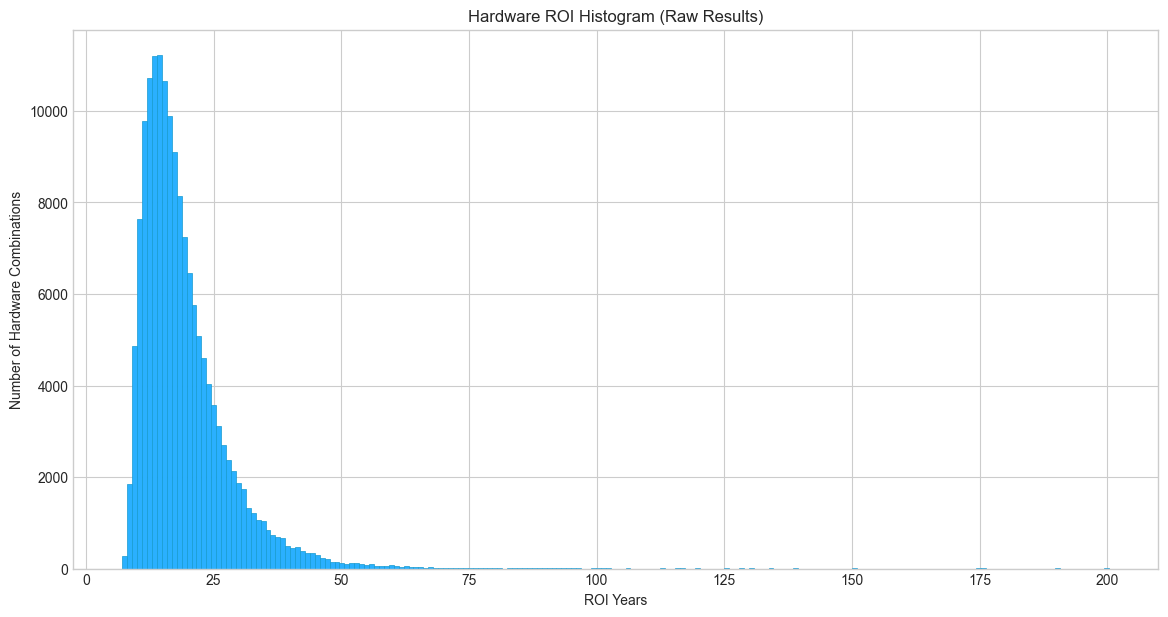

In [55]:
# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(results_df['realRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware ROI Histogram (Raw Results)') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

## Filtering to Favorable ROIs

In [56]:
#filter out anything with an ROI over its working years
favROI_df = results_df[results_df['realRoi'] <= results_df['workingLife']] 

favROI_df_Z = favROI_df[favROI_df['immediateEventAmt'] == 0] 
favROI_df_O = favROI_df[favROI_df['immediateEventAmt'] == 1] 
favROI_df_F = favROI_df[favROI_df['immediateEventAmt'] == 5] 

In [57]:
#get total combinations by azimuth, frequency, and network

print('Total Combinations')
print(str(favROI_df.shape[0])+ ' total favorable ROI hardware combinations generated')
print(str(favROI_df_Z.shape[0])+ ' total favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O.shape[0])+ ' total favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F.shape[0])+ ' total favorable ROI hardware combinations generated - Five Immediate Event')
print('')

print('Eastern')
print(str(favROI_df[favROI_df['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - Five Immediate Event')
print('Impact: ' + str(favROI_df_Z[favROI_df_Z['az']==110].shape[0]/favROI_df_F[favROI_df_F['az']==110].shape[0])) #the closer to 1, the less impactful
print('')

print('Southern')
print(str(favROI_df[favROI_df['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - Five Immediate Event')
print('Impact: ' + str(favROI_df_Z[favROI_df_Z['az']==180].shape[0]/favROI_df_F[favROI_df_F['az']==180].shape[0])) #the closer to 1, the less impactful
print('')

print('Western')
print(str(favROI_df[favROI_df['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated - Five Immediate Event')
print('Impact: ' + str(favROI_df_Z[favROI_df_Z['az']==250].shape[0]/favROI_df_F[favROI_df_F['az']==250].shape[0])) #the closer to 1, the less impactful


Total Combinations
4292 total favorable ROI hardware combinations generated
1471 total favorable ROI hardware combinations generated - Zero Immediate Event
1449 total favorable ROI hardware combinations generated - One Immediate Event
1372 total favorable ROI hardware combinations generated - Five Immediate Event

Eastern
1038 eastern favorable ROI hardware combinations generated
349 eastern favorable ROI hardware combinations generated - Zero Immediate Event
349 eastern favorable ROI hardware combinations generated - One Immediate Event
340 eastern favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.026470588235294

Southern
2177 southern favorable ROI hardware combinations generated
745 southern favorable ROI hardware combinations generated - Zero Immediate Event
733 southern favorable ROI hardware combinations generated - One Immediate Event
699 southern favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.0658082975679541

Wester

In [58]:
for n in myNetworks:
    print('Network: ' + n)
    tempDF = favROI_df[favROI_df['network']==n]

    tempDF_Z = tempDF[tempDF['immediateEventAmt'] == 0]
    tempDF_O = tempDF[tempDF['immediateEventAmt'] == 1]
    tempDF_F = tempDF[tempDF['immediateEventAmt'] == 5]

    print('Total Combinations')
    print(str(tempDF.shape[0])+ ' total favorable ROI hardware combinations generated')
    print(str(tempDF_Z.shape[0])+ ' total favorable ROI hardware combinations generated - Zero Immediate Event')
    print(str(tempDF_O.shape[0])+ ' total favorable ROI hardware combinations generated - One Immediate Event')
    print(str(tempDF_F.shape[0])+ ' total favorable ROI hardware combinations generated - Five Immediate Event')
    print('Impact: ' + str(tempDF_Z.shape[0]/tempDF_F.shape[0])) #the closer to 1, the less impactful
    
    print('')

Network: bowling green
Total Combinations
860 total favorable ROI hardware combinations generated
293 total favorable ROI hardware combinations generated - Zero Immediate Event
290 total favorable ROI hardware combinations generated - One Immediate Event
277 total favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.0577617328519855

Network: long island city
Total Combinations
542 total favorable ROI hardware combinations generated
184 total favorable ROI hardware combinations generated - Zero Immediate Event
183 total favorable ROI hardware combinations generated - One Immediate Event
175 total favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.0514285714285714

Network: sunnyside
Total Combinations
336 total favorable ROI hardware combinations generated
113 total favorable ROI hardware combinations generated - Zero Immediate Event
113 total favorable ROI hardware combinations generated - One Immediate Event
110 total favorable RO

In [59]:
#network combos by azimuth
print("Network combos by azimuth - Zero Immediate Event")
for n in myNetworks:
    print('Network: ' + n)
    tempDF = favROI_df[favROI_df['network']==n]
    tempDF_Z = tempDF[tempDF['immediateEventAmt'] == 0]

    for a in [110,180,250]:
        print('Azimuth ' + str(a) + ": " + str(tempDF_Z[tempDF_Z['az']==a].shape[0])+ ' total favorable ROI hardware combinations generated')
    print('')

Network combos by azimuth - Zero Immediate Event
Network: bowling green
Azimuth 110: 77 total favorable ROI hardware combinations generated
Azimuth 180: 137 total favorable ROI hardware combinations generated
Azimuth 250: 79 total favorable ROI hardware combinations generated

Network: long island city
Azimuth 110: 38 total favorable ROI hardware combinations generated
Azimuth 180: 94 total favorable ROI hardware combinations generated
Azimuth 250: 52 total favorable ROI hardware combinations generated

Network: sunnyside
Azimuth 110: 24 total favorable ROI hardware combinations generated
Azimuth 180: 63 total favorable ROI hardware combinations generated
Azimuth 250: 26 total favorable ROI hardware combinations generated

Network: crown heights
Azimuth 110: 20 total favorable ROI hardware combinations generated
Azimuth 180: 53 total favorable ROI hardware combinations generated
Azimuth 250: 15 total favorable ROI hardware combinations generated

Network: grasslands
Azimuth 110: 6 tota

In [60]:
#median performance

print('Median DR Performance - Watts')
print('')

print(str(favROI_df['avgMAPw_C'].median())+ ' Median CSRP - Total')
print(str(favROI_df['avgMAPw_D'].median())+ ' Median DRLP - Total')
print(str(favROI_df_Z['avgMAPw_C'].median())+ ' Median CSRP - Zero')
print(str(favROI_df_Z['avgMAPw_D'].median())+ ' Median DRLP - Zero')
print(str(favROI_df_O['avgMAPw_C'].median())+ ' Median CSRP - One')
print(str(favROI_df_O['avgMAPw_D'].median())+ ' Median DRLP - One')
print(str(favROI_df_F['avgMAPw_C'].median())+ ' Median CSRP - Five')
print(str(favROI_df_F['avgMAPw_D'].median())+ ' Median DRLP - Five')

for a in [110,180,250]:
    print('')
    print(str(a) + ' degrees')
    print('DRLP')
    #print(str(favROI_df[favROI_df['az']==a]['avgMAPw_D'].median())+ ' eastern favorable ROI hardware combinations generated')
    print(str(favROI_df_Z[favROI_df_Z['az']==a]['avgMAPw_D'].median())+ ' DLRP Median Performance - Zero Immediate Event')
    print(str(favROI_df_O[favROI_df_O['az']==a]['avgMAPw_D'].median())+ ' DLRP Median Performance - One Immediate Event')
    print(str(favROI_df_F[favROI_df_F['az']==a]['avgMAPw_D'].median())+ ' DLRP Median Performance - Five Immediate Event')
    print('CSRP')
    #print(str(favROI_df[favROI_df['az']==a]['avgMAPw_C'].median())+ ' eastern favorable ROI hardware combinations generated')
    print(str(favROI_df_Z[favROI_df_Z['az']==a]['avgMAPw_C'].median())+ ' CRSP Median Performance - Zero Immediate Event')
    print(str(favROI_df_O[favROI_df_O['az']==a]['avgMAPw_C'].median())+ ' CRSP - One Immediate Event')
    print(str(favROI_df_F[favROI_df_F['az']==a]['avgMAPw_C'].median())+ ' CRSP - Five Immediate Event')

Median DR Performance - Watts

271.01549962000604 Median CSRP - Total
196.1077289442773 Median DRLP - Total
274.36239173245895 Median CSRP - Zero
205.63087533464773 Median DRLP - Zero
271.59291965138044 Median CSRP - One
196.1077289442773 Median DRLP - One
266.64676823356234 Median CSRP - Five
196.1077289442773 Median DRLP - Five

110 degrees
DRLP
196.1077289442773 DLRP Median Performance - Zero Immediate Event
196.1077289442773 DLRP Median Performance - One Immediate Event
196.1077289442773 DLRP Median Performance - Five Immediate Event
CSRP
266.64676823356234 CRSP Median Performance - Zero Immediate Event
266.64676823356234 CRSP - One Immediate Event
266.64676823356234 CRSP - Five Immediate Event

180 degrees
DRLP
205.63087533464773 DLRP Median Performance - Zero Immediate Event
205.63087533464773 DLRP Median Performance - One Immediate Event
196.1077289442773 DLRP Median Performance - Five Immediate Event
CSRP
276.2841272401438 CRSP Median Performance - Zero Immediate Event
275.2255

In [61]:
#ROI data

#arg: results DF
def snapShot(rDF):
    
    #lifespan
    print("Min Lifespan: " + str(min(rDF['lifespan'])))
    print("Mean Lifespan: " + str(rDF['lifespan'].mean()))
    print("Median Lifespan: " + str(rDF['lifespan'].median()))
    print("Max Lifespan: " + str(max(rDF['lifespan'])))
    print('')

    #working life
    print("Min working life: " + str(min(rDF['workingLife'])))
    print("Mean working life: " + str(rDF['workingLife'].mean()))
    print("Median working life: " + str(rDF['workingLife'].median()))
    print("Max working life: " + str(max(rDF['workingLife'])))
    print('')
    
    # fastest ROI
    fARoi = rDF[rDF['realRoi'] == min(rDF['realRoi'])]
    print("Fastest ROI: " + str(fARoi['realRoi'].iloc[0]) + "yrs")

    mARoi = rDF['realRoi'].mean()
    print("Mean ROI: " + str(mARoi))
    
    print("Median ROI: " + str(rDF['realRoi'].median()))
    # slowest ROI
    sARoi = rDF[rDF['realRoi'] == max(rDF['realRoi'])]
    print("Slowest ROI: " + str(sARoi['realRoi'].iloc[0]) + "yrs")

    print('')

    # Income After ROI
    maxAIAR = rDF[rDF['incomeAfterRoi'] == max(rDF['incomeAfterRoi'])]
    print("Greatest IAR: $" + str(maxAIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(maxAIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxAIAR['lifespan'].iloc[0])) +' years)')

    mAIRoi = rDF['incomeAfterRoi'].mean()
    print("Mean IROI: " + str(mAIRoi))

    print("Median IROI: " + str(rDF['incomeAfterRoi'].median()))
    
    minAIAR = rDF[rDF['incomeAfterRoi'] == min(rDF['incomeAfterRoi'])]
    print("Lowest IAR: $" + str(minAIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(minAIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,minAIAR['lifespan'].iloc[0])) +' years)')

    print('')
    
    # Income After ROI Split
    print("Greatest IAR Split: $" + str(max(rDF['iarSplit'])))

    print("Mean IAR Split: " + str(rDF['iarSplit'].mean()))
    print("Median IAR Split: " + str(rDF['iarSplit'].median()))

    print("Lowest IAR Split: $" + str(min(rDF['iarSplit'])))

    print('')
    
    #min PV
    md = rDF[rDF['pvW'] == min(rDF['pvW'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Minimum PV Arrays: ")
    print(set(a))
    
    #max PV
    md = rDF[rDF['pvW'] == max(rDF['pvW'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Maximum PV Arrays: ")
    print(set(a))  
    
    print("mean PV: " + str(rDF['pvW'].mean()))
    print("median PV: " + str(rDF['pvW'].median()))

    print('')

    #min BAT
    md = rDF[rDF['batWh'] == min(rDF['batWh'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Minimum Bat Wh: ")
    print(set(a))
    
    #max BAT
    md = rDF[rDF['batWh'] == max(rDF['batWh'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Maximum Bat Wh: ")
    print(set(a))  

    print("mean Bat Wh: " + str(rDF['batWh'].mean()))
    print("median Bat Wh: " + str(rDF['batWh'].median()))
    print('')

    #min BATAC
    md = rDF[rDF['batWhAC'] == min(rDF['batWhAC'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWhAC']]
        a.append(str(m))
    print("Combinations with Minimum Bat Wh AC: ")
    print(set(a))
    

    #max BATAC
    md = rDF[rDF['batWhAC'] == max(rDF['batWhAC'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWhAC']]
        a.append(str(m))
    print("Combinations with Maximum Bat Wh AC: ")
    print(set(a))  

    print("mean Bat Wh AC: " + str(rDF['batWhAC'].mean()))
    print("median Bat Wh AC: " + str(rDF['batWhAC'].median()))

    print('')

    #CSRP performance
    print("Min CSRP W Performance: " + str(round(min(rDF['avgMAPw_C']),2)))
    print("Mean CSRP W Performance: " + str(round(rDF['avgMAPw_C'].mean(),2)))
    print("Median CSRP W Performance: " + str(round(rDF['avgMAPw_C'].median(),2)))
    print("Max CSRP W Performance: " + str(round(max(rDF['avgMAPw_C']),2)))

    print('')

    #DLRP performance
    print("Min DLRP W Performance: " + str(round(min(rDF['avgMAPw_D']),2)))
    print("Mean DLRP W Performance: " + str(round(rDF['avgMAPw_D'].mean(),2)))
    print("Median DLRP W Performance: " + str(round(rDF['avgMAPw_D'].median(),2)))
    print("Max DLRP W Performance: " + str(round(max(rDF['avgMAPw_D']),2)))
    
    
snapShot(favROI_df)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.669471077123415
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.60397809240511
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 7.166666666666667yrs
Mean ROI: 9.022231283007146
Median ROI: 9.166666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $450.2616886342059 ($46.95586181471005/per year for 9.58904109589041 years)
Mean IROI: 96.25539380145985
Median IROI: 78.60031222051785
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $46.95586181471005
Mean IAR Split: 10.032501856469244
Median IAR Split: 8.196889702996863
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[260, 614.0]', '[260, 960.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2048.0]', '[500, 1920.0]', '[500, 1440.0]', '[500, 1536.0]', '[500, 680.96]', '[500, 2000.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 2232.0]'}
mean PV: 421.2022367194781
me

In [62]:
# snapShot(favROI_df_Z)

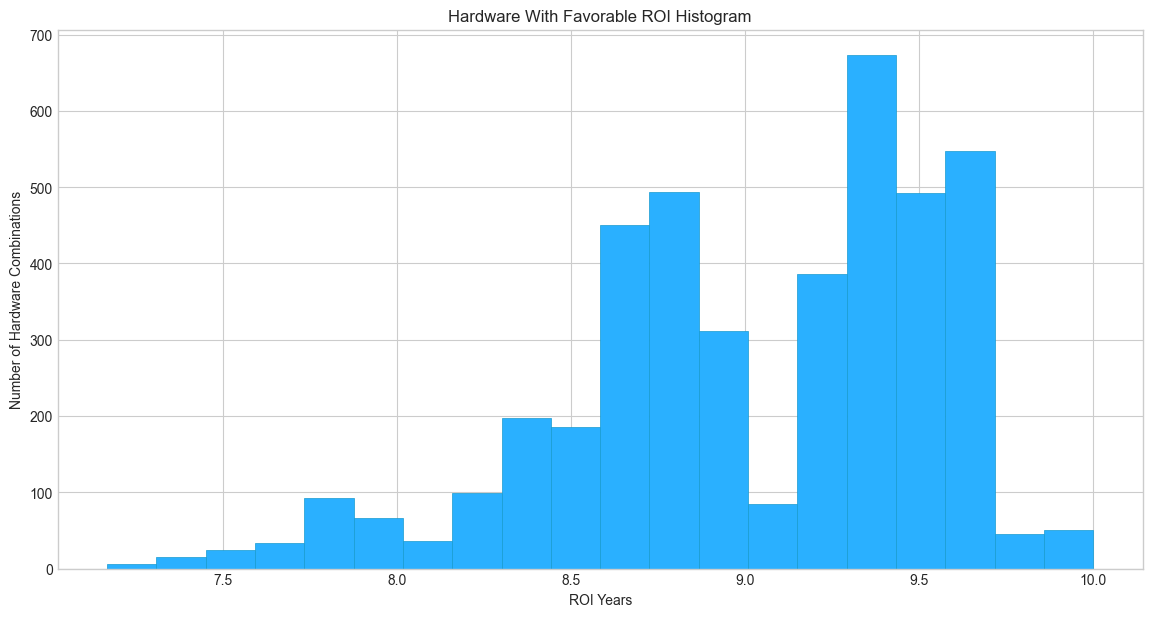

In [63]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['realRoi'], bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


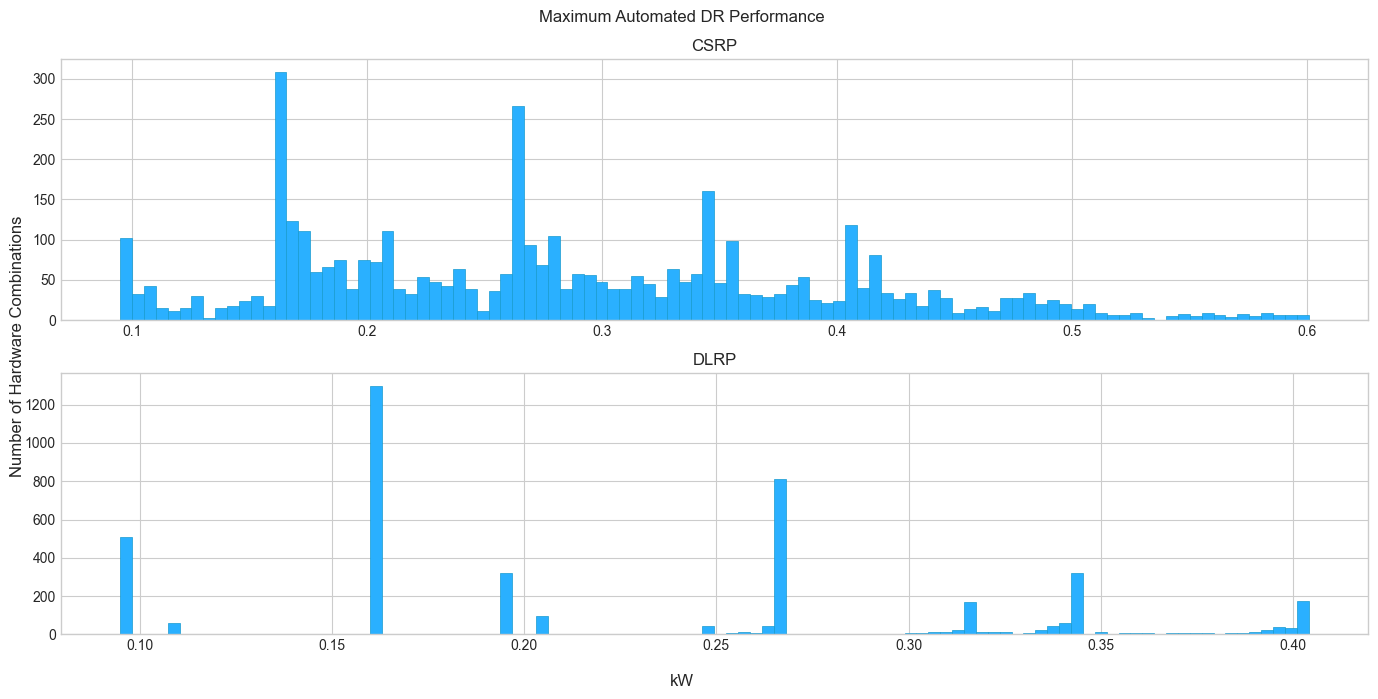

In [64]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(14, 7))
fig.suptitle('Maximum Automated DR Performance') 

ax1.hist(favROI_df['avgMAPw_C'] *0.001, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
ax1.set_title("CSRP")
ax2.hist(favROI_df['avgMAPw_D'] *0.001, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
ax2.set_title("DLRP")

#ax1.set(xlabel='kW',ylabel="Number of Hardware Combinations")
#ax2.set(xlabel='kW',ylabel="Number of Hardware Combinations")

fig.supxlabel('kW')
fig.supylabel('Number of Hardware Combinations')

#fig.set(ylabel='Number of Hardware Combinations')

fig.subplots_adjust(bottom=0, top=1.5)

fig.tight_layout(pad=1.0)
#fig.style.use('seaborn-whitegrid') # nice and clean grid
#ax1.xlabel('Max Auto kW') 
fig.show()


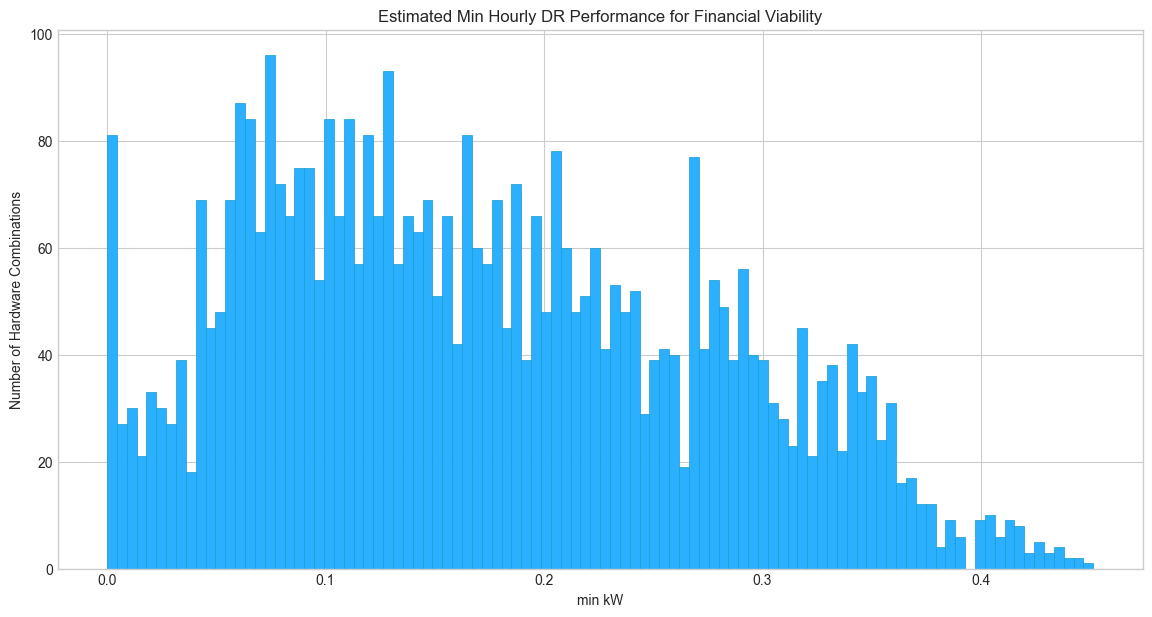

In [65]:
# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['minDRkWperf'], bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Estimated Min Hourly DR Performance for Financial Viability') 
plt.xlabel('min kW') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware Combinations'}, xlabel='Battery Wh', ylabel='PV Array W'>

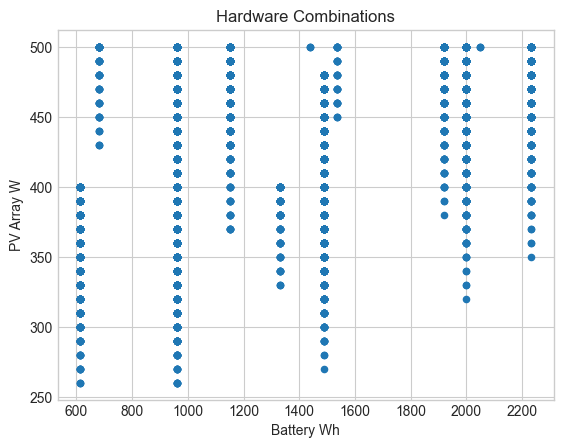

In [66]:
#hardare combos
favROI_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW',title='Hardware Combinations',xlabel="Battery Wh",ylabel="PV Array W")


# Analysis

To analize:
* impact of network characteristics
* time and overall quantity
* relationship between azimuth and time

## Overall - Zero Immediate Events

* Fastest ROI
* Greatest IAR
* Greatest DR impact
* Greatest PV generation DC
* Greatest avoided grid energy

In [67]:
snapShot(favROI_df_Z)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.667265768324594
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.603568535056759
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 7.166666666666667yrs
Mean ROI: 9.028382053025153
Median ROI: 9.166666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $450.2616886342059 ($46.95586181471005/per year for 9.58904109589041 years)
Mean IROI: 95.55702409368867
Median IROI: 78.44456713205986
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $46.95586181471005
Mean IAR Split: 9.959824339786902
Median IAR Split: 8.180647715200529
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[260, 614.0]', '[260, 960.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2048.0]', '[500, 1920.0]', '[500, 1440.0]', '[500, 1536.0]', '[500, 680.96]', '[500, 2000.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 2232.0]'}
mean PV: 420.46227056424203
m

In [68]:
# fastest ROI
fRoi = favROI_df_Z[favROI_df_Z['realRoi'] == min(favROI_df_Z['realRoi'])]
print("Fastest ROI: " + str(fRoi['realRoi'].iloc[0]) + "yrs")
# slowest ROI
sRoi = favROI_df_Z[favROI_df_Z['realRoi'] == max(favROI_df_Z['realRoi'])]
print("Slowest ROI: " + str(sRoi['realRoi'].iloc[0]) + "yrs")


Fastest ROI: 7.166666666666667yrs
Slowest ROI: 10.0yrs


Greatest IAR: $450.2616886342059 ($46.95586181471005/per year for 9.58904109589041 years)
Lowest IAR: $0.0 ($0.0/per year for 9.58904109589041 years)
Amount with 0 IAR: 190


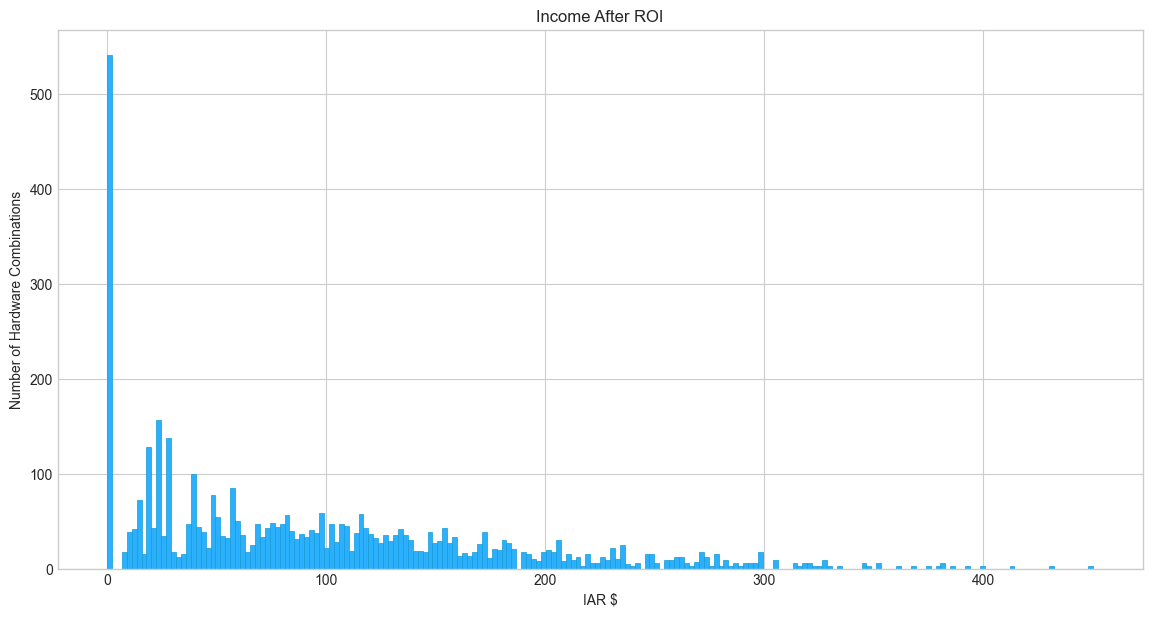

In [69]:
# Income After ROI
maxIAR = favROI_df_Z[favROI_df_Z['incomeAfterRoi'] == max(favROI_df_Z['incomeAfterRoi'])]
print("Greatest IAR: $" + str(maxIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(maxIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxIAR['lifespan'].iloc[0])) +' years)')

minIAR = favROI_df_Z[favROI_df_Z['incomeAfterRoi'] == min(favROI_df_Z['incomeAfterRoi'])]
print("Lowest IAR: $" + str(minIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(minIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxIAR['lifespan'].iloc[0])) +' years)')

print('Amount with 0 IAR: ' + str(favROI_df_Z[favROI_df_Z['incomeAfterRoi'] == 0].shape[0]))
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Income After ROI') 
plt.xlabel('IAR $') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware'}, xlabel='batWh', ylabel='pvW'>

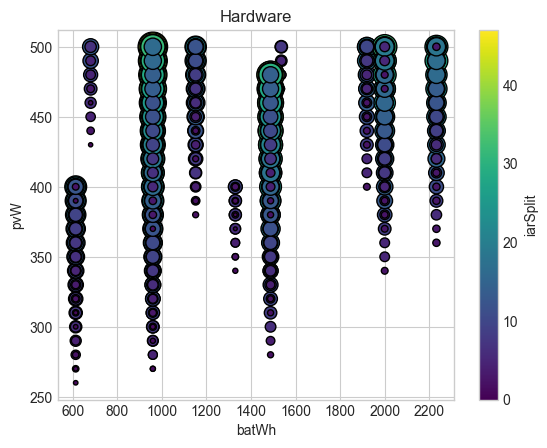

In [70]:
favROI_df_Z.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='iarSplit',s='incomeAfterRoi',colormap='viridis',edgecolor='black', title='Hardware')


<AxesSubplot:title={'center':'Hardware w/ IAR >= $300'}, xlabel='batWh', ylabel='pvW'>

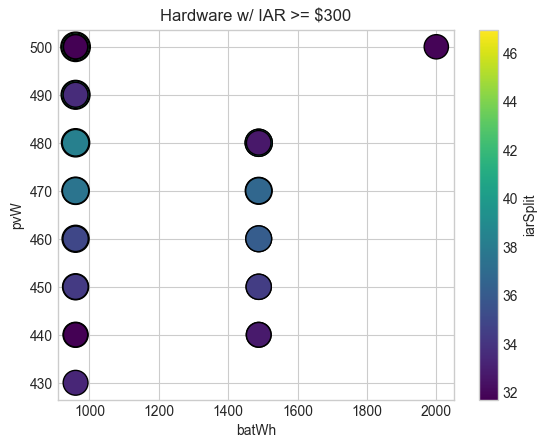

In [71]:
# High IAR

highIAR = favROI_df_Z[favROI_df_Z['incomeAfterRoi'] >= 300]

highIAR.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='iarSplit',s='incomeAfterRoi',colormap='viridis',edgecolor='black', title='Hardware w/ IAR >= $300')

# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(highIAR['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Income After ROI ($0 IAR not shown)') 
# plt.xlabel('IAR $') 
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


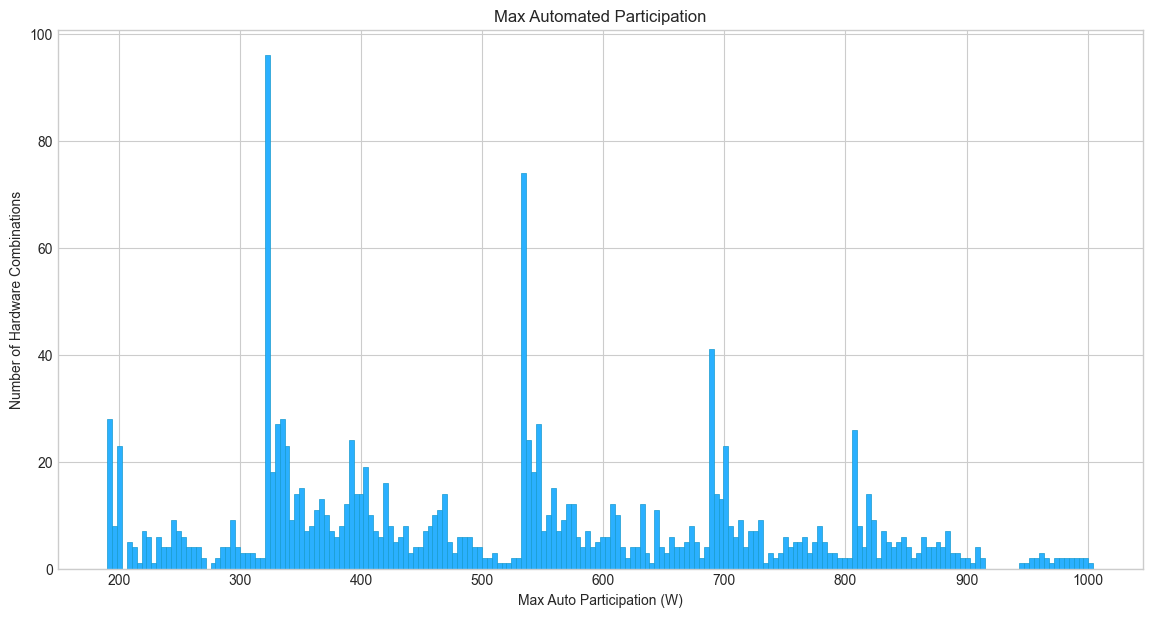

In [72]:
favROI_df_Z['avgMAPw'] = favROI_df_Z['avgMAPw_C'] + favROI_df_Z['avgMAPw_D']

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['avgMAPw'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Max Automated Participation') 
plt.xlabel('Max Auto Participation (W)') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

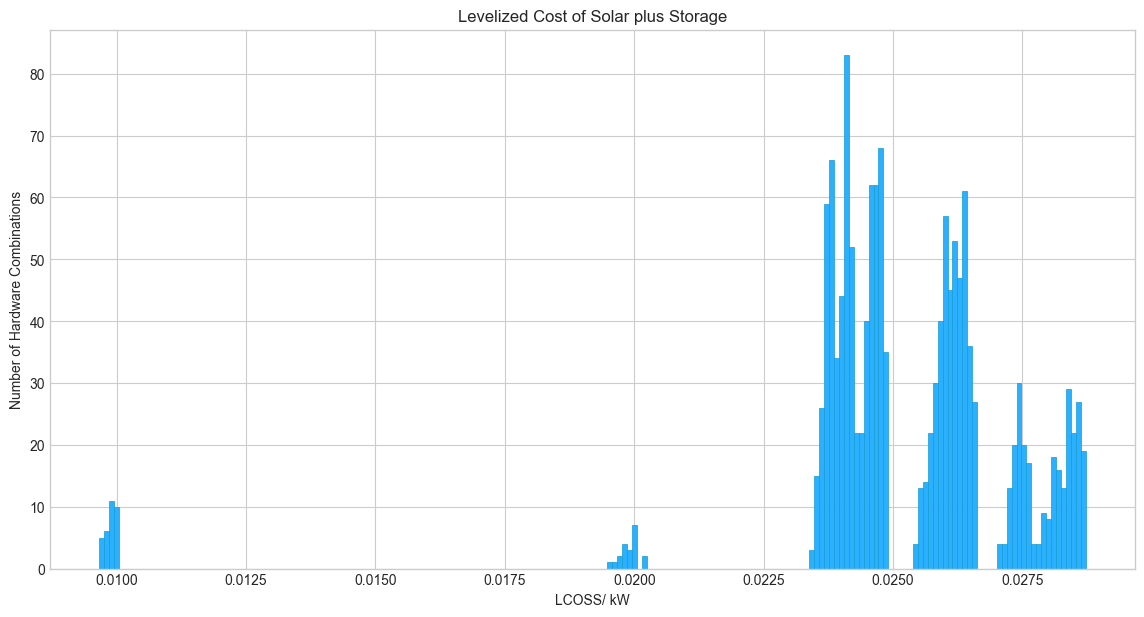

In [73]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['LCOSS'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Levelized Cost of Solar plus Storage') 
plt.xlabel('LCOSS/ kW') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

In [74]:
#levelized cost compaprison
#https://www.statista.com/statistics/493797/estimated-levelized-cost-of-energy-generation-in-the-us-by-technology/
#2023 commercial solar + store lcoe: $46-102/ per megawatts

print(46/1000)
print(102/1000)

0.046
0.102


## Impact of Network Characteristics

Below this point, only favorable ROI combinations are considered.

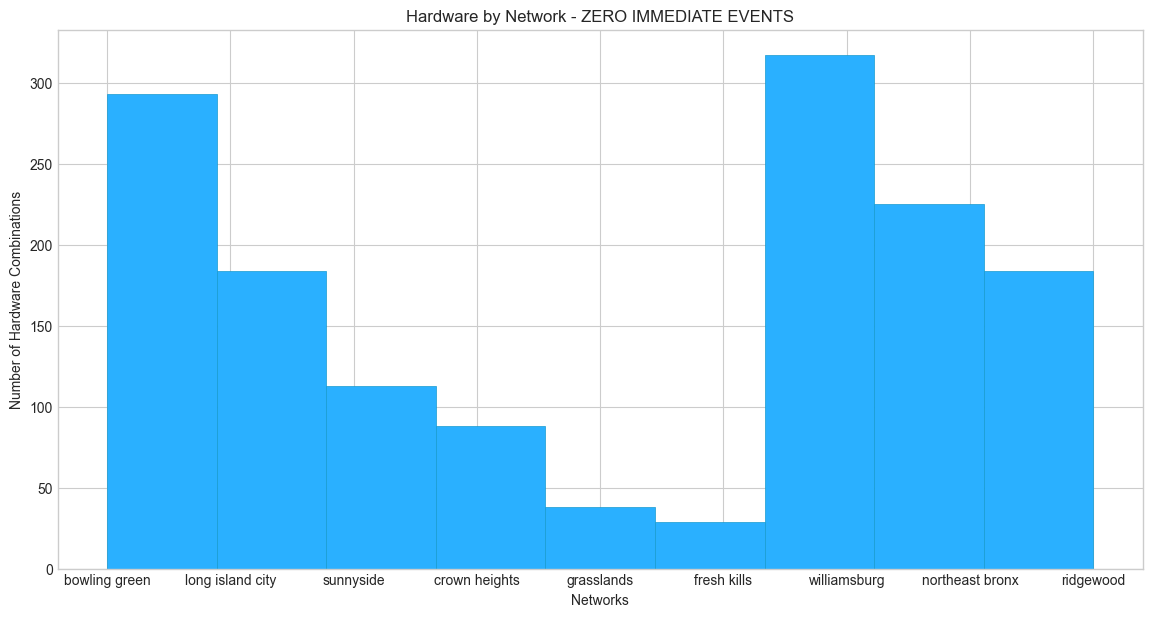

In [75]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware by Network - ZERO IMMEDIATE EVENTS') 
plt.xlabel('Networks') 
#plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
plt.ylabel('Number of Hardware Combinations') 
plt.show()

In [76]:
# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(favROI_df_O['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Hardware by Network - ONE IMMEDIATE EVENTS') 
# plt.xlabel('Networks') 
# #plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

In [77]:
# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(favROI_df_F['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Hardware by Network - FIVE IMMEDIATE EVENTS') 
# plt.xlabel('Networks') 
# #plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

<AxesSubplot:title={'center':'ROIs'}, xlabel='realRoi', ylabel='eventStart'>

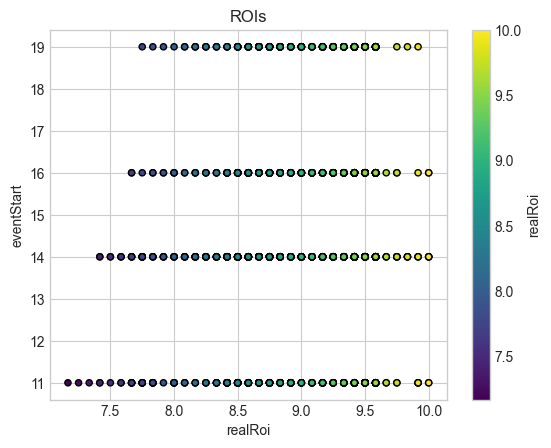

In [78]:
favROI_df_Z.plot(kind = 'scatter', x = 'realRoi', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='ROIs')


In [79]:
#build a data frame with characteristics by neighborhood

#regardless of azimuth
nFavorable = {
    "name":[],
    "total amount":[],
    "start time":[],
    "dr rate $":[],
    "min PV":[],
    "min PV bat Wh":[], #the battery that pairs with the min PV module
    "max PV":[],
    "max PV bat Wh":[], #the battery that pairs with the max PV module
    "min bat":[],
    "min bat PV W":[], #the PV modules that pair with the min battery
    "max bat":[],
    "max bat PV W":[], #the PV modules that pair with the max battery
    "min capex":[],
    "max capex":[],
    #avg capex is kind of meaningless,
    #because lower call times have both cheaper and most expensive system,
    #so just a wider range of possibilities
    "avg capex":[], 
    "min ROI":[],
    "max ROI":[],
    "avg ROI":[],
    "min IAR":[],
    "max IAR":[],
    "avg IAR":[],
    "min DR":[],
    "max DR":[],
    "avg DR":[]
}
for n in myNetworks:
    tNAz = favROI_df_Z[favROI_df_Z['network'] == n]
    tN = tNAz#[tNAz['az'] == 180] #uncomment to filter by azimuth
    nFavorable['name'].append(n)
    
    nFavorable['start time'].append(getStartTime(n))
    nFavorable['dr rate $'].append(getTotalRate(n))
    
    if tN.shape[0] != 0:
        nFavorable['total amount'].append(tN.shape[0])
    
        #min PV
        tNminMax = tN[tN['pvW'] == min(tN['pvW'])]
        nFavorable['min PV'].append(min(tN['pvW']))
        nFavorable['min PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #max PV
        tNminMax = tN[tN['pvW'] == max(tN['pvW'])]
        nFavorable['max PV'].append(max(tN['pvW']))
        nFavorable['max PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #min BAT
        tNminMax = tN[tN['batWh'] == min(tN['batWh'])]
        nFavorable['min bat'].append(min(tN['batWh']))
        nFavorable['min bat PV W'].append(list(set(tNminMax['pvW'])))

        #max BAT
        tNminMax = tN[tN['batWh'] == max(tN['batWh'])]
        nFavorable['max bat'].append(max(tN['batWh']))
        nFavorable['max bat PV W'].append(list(set(tNminMax['pvW'])))

        nFavorable['min capex'].append(min(tN['capex']))
        nFavorable['max capex'].append(max(tN['capex']))
        nFavorable['avg capex'].append(tN['capex'].mean())
        nFavorable['min ROI'].append(min(tN['realRoi']))
        nFavorable['max ROI'].append(max(tN['realRoi']))
        nFavorable['avg ROI'].append(tN['realRoi'].mean())
        
        nFavorable['min IAR'].append(min(tN['incomeAfterRoi']))
        nFavorable['max IAR'].append(max(tN['incomeAfterRoi']))
        nFavorable['avg IAR'].append(tN['incomeAfterRoi'].mean())

        mDR = []
        for y in range(len(tN['maxAutoParticipationW_C'])):
            print(list(tN['maxAutoParticipationW_C']))
            yC = sum(list(tN['maxAutoParticipationW_C'])[y])
            yD = sum(list(tN['maxAutoParticipationW_D'])[y])
            mDR.append(sum([yC,yD])/len(list(tN['maxAutoParticipationW_C'])[y]))

        nFavorable['min DR'].append(min(mDR))
        nFavorable['max DR'].append(max(mDR))
        nFavorable['avg DR'].append(sum(mDR)/len(mDR))
    else:
        for k in ['total amount','min PV','min PV bat Wh','max PV','max PV bat Wh',
                  'min bat','min bat PV W','max bat','max bat PV W',
                  'min capex','max capex','avg capex','min ROI','max ROI',
                  'avg ROI','min IAR','max IAR','avg IAR','min DR','max DR','avg DR']:
            nFavorable[k].append(0)

networkResults_df = pd.DataFrame.from_dict(nFavorable)
networkResults_df

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783], [94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783], [94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783], [94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783], [94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783], [94.93909180434783, 94.93909180434783, 

,name,total amount,start time,dr rate $,min PV,min PV bat Wh,max PV,max PV bat Wh,min bat,min bat PV W,...,avg capex,min ROI,max ROI,avg ROI,min IAR,max IAR,avg IAR,min DR,max DR,avg DR
0,bowling green,293,11,36,260,"[960.0, 614.0]",500,"[1536.0, 1152.0, 1920.0, 1440.0, 960.0, 680.96...",614.0,"[320, 290, 260, 390, 360, 330, 300, 270, 400, ...",...,1385.702029,7.166667,10.000000,8.912116,0.0,450.261689,116.436670,277.699824,1004.799376,611.673692
1,long island city,184,14,36,290,"[960.0, 614.0]",500,"[1152.0, 1920.0, 960.0, 680.96, 2000.0, 2232.0]",614.0,"[320, 290, 390, 360, 330, 300, 400, 370, 340, ...",...,1342.144570,7.583333,9.916667,9.024457,0.0,348.551738,93.049822,219.571570,912.228348,507.915629
2,sunnyside,113,16,36,320,"[960.0, 614.0]",500,"[1920.0, 1152.0, 960.0, 2000.0, 2232.0]",614.0,"[320, 390, 360, 330, 400, 370, 340, 380, 350]",...,1310.357804,7.916667,9.583333,9.117994,0.0,277.853515,74.928227,193.975179,822.241324,434.425980
3,crown heights,88,19,36,330,"[960.0, 614.0]",500,"[1152.0, 2000.0, 2232.0, 960.0]",614.0,"[390, 360, 330, 400, 370, 340, 380, 350]",...,1309.083472,8.083333,9.583333,9.156250,0.0,250.588258,68.528046,189.878184,808.084292,417.879174
4,grasslands,38,14,24,350,[614.0],500,[960.0],614.0,"[390, 360, 400, 370, 380, 350]",...,1199.715973,8.416667,9.583333,9.206140,0.0,190.775698,57.199800,243.050252,613.081772,404.938328
5,fresh kills,29,16,24,370,[614.0],500,[960.0],614.0,"[400, 370, 380, 390]",...,1209.254227,8.583333,9.583333,9.270115,0.0,156.745249,47.689738,200.490747,548.115840,347.826306
6,williamsburg,317,14,43,260,[960.0],500,"[1536.0, 1152.0, 1920.0, 2048.0, 960.0, 680.96...",614.0,"[320, 290, 390, 360, 330, 300, 270, 400, 370, ...",...,1415.315136,7.416667,10.000000,8.956362,0.0,400.377169,112.597681,217.514956,912.228348,556.690792
7,northeast bronx,225,16,43,280,[960.0],500,"[1536.0, 1152.0, 1920.0, 960.0, 680.96, 2000.0...",614.0,"[320, 290, 390, 360, 330, 300, 400, 370, 340, ...",...,1403.749973,7.666667,10.000000,9.070370,0.0,327.487528,89.893148,193.611723,834.839661,504.412683
8,ridgewood,184,19,43,290,[960.0],500,"[1920.0, 1152.0, 960.0, 2000.0, 2232.0]",614.0,"[320, 390, 360, 330, 400, 370, 340, 310, 380, ...",...,1402.499190,7.750000,9.916667,9.099185,0.0,304.271123,83.445081,189.878184,808.084292,492.238765


In [80]:
results_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batWh', 'batWhAC', 'effEff',
       'gridChargeTime', 'dischargeRateW', 'capex', 'dollarPerBatkWh',
       'annualPVkWhDC_degraded', 'annualPVkWhAC_degraded', 'avoidedGridCosts',
       'immediateEventAmt', 'maxAutoParticipationMonthlyW_C',
       'maxAutoParticipationMonthlyW_D', 'maxAutoParticipationW_C',
       'maxAutoParticipationW_D', 'avgMAPw_C', 'avgMAPw_D', 'totalDRratekW',
       'drIncMonthly_C', 'drIncMonthly_D', 'drIncAnnual_C', 'drIncAnnual_D',
       'drPerformanceIncome', 'minDRinc', 'minDRkWperf', 'annualIncome',
       'LCOSS', 'realRoi', 'Cycles', 'lifespan', 'workingLife',
       'profitableYears', 'incomeAfterRoi', 'iarSplit'],
      dtype='object')

In [81]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

# bPD = favROI_df[favROI_df['az'] == 250]
    
# boxPlotData = {}
# for n in myNetworks:
#     bP = bPD[bPD['network'] == n]
#     #print(bP['maxAutoParticipationW'].head())
#     #the full label thing doesn't work when some results are 0
#     #print(type(list(bP['maxAutoParticipationW'])))
#     boxPlotData[n]=bP['maxAutoParticipationW']# + "\n("+ str(bP.iloc[0]['eventStart']) + ", $" + str(bP.iloc[0]['totalDRratekW']) +")"]=bP['maxAutoParticipationW']

# boxPlot_df = pd.DataFrame.from_dict(boxPlotData)
# boxPlot_df.boxplot(figsize=(14,7))

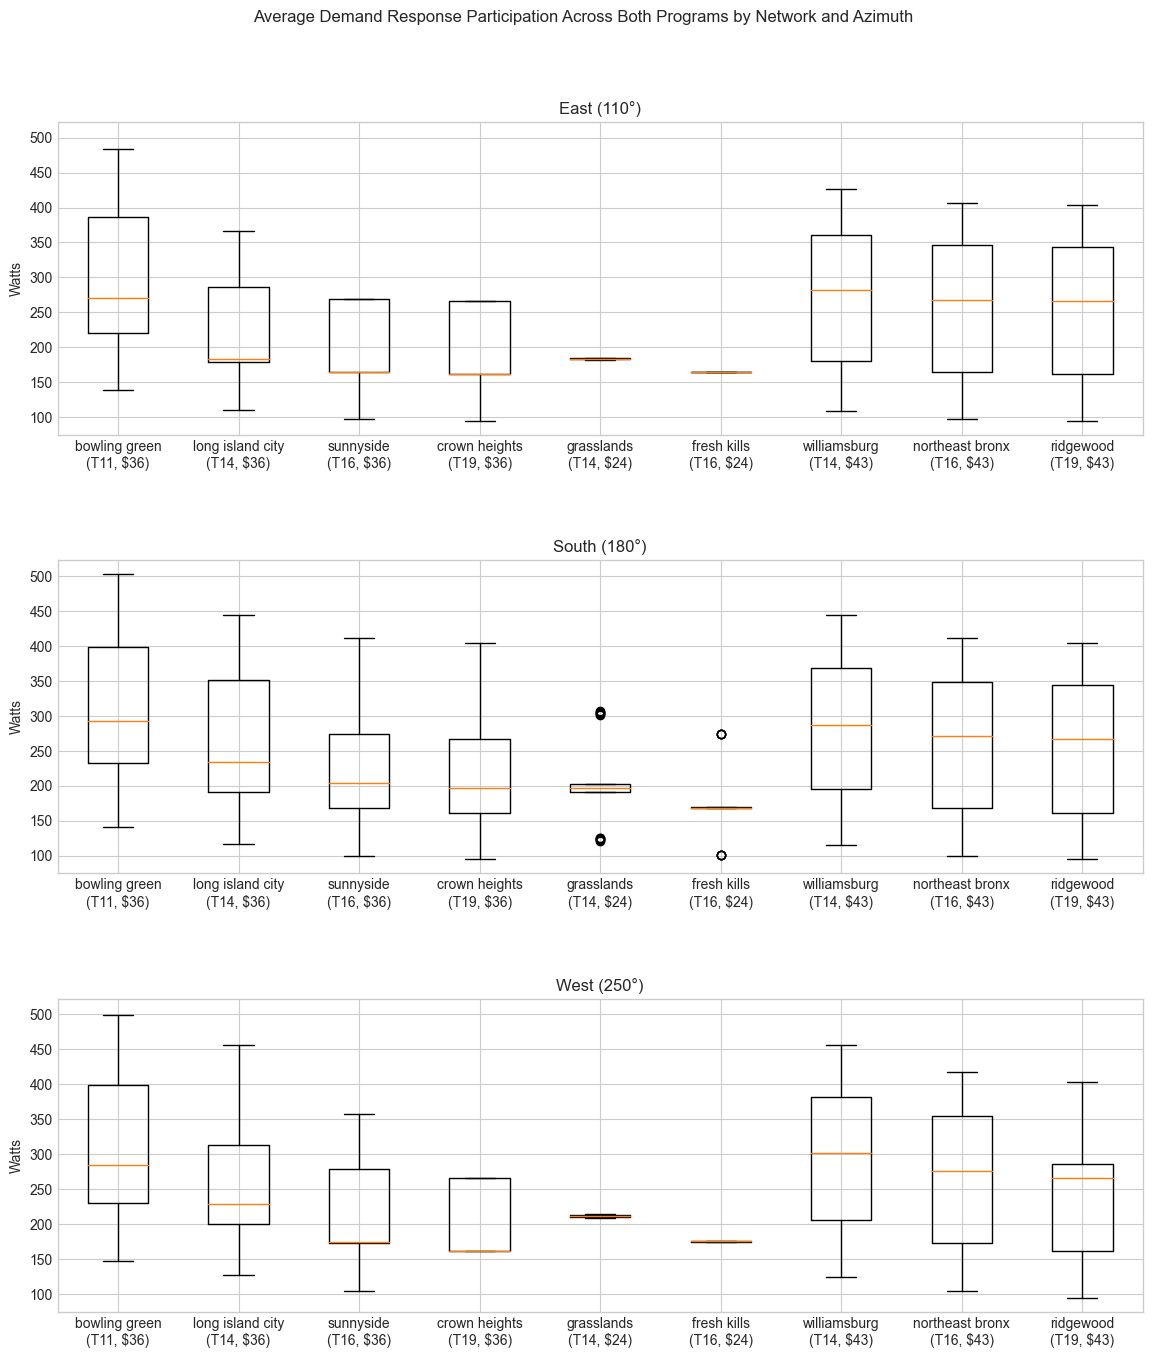

In [82]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list((bP['avgMAPw_C'] + bP['avgMAPw_D']) * .5))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('Average Demand Response Participation Across Both Programs by Network and Azimuth')
    
plt.show()

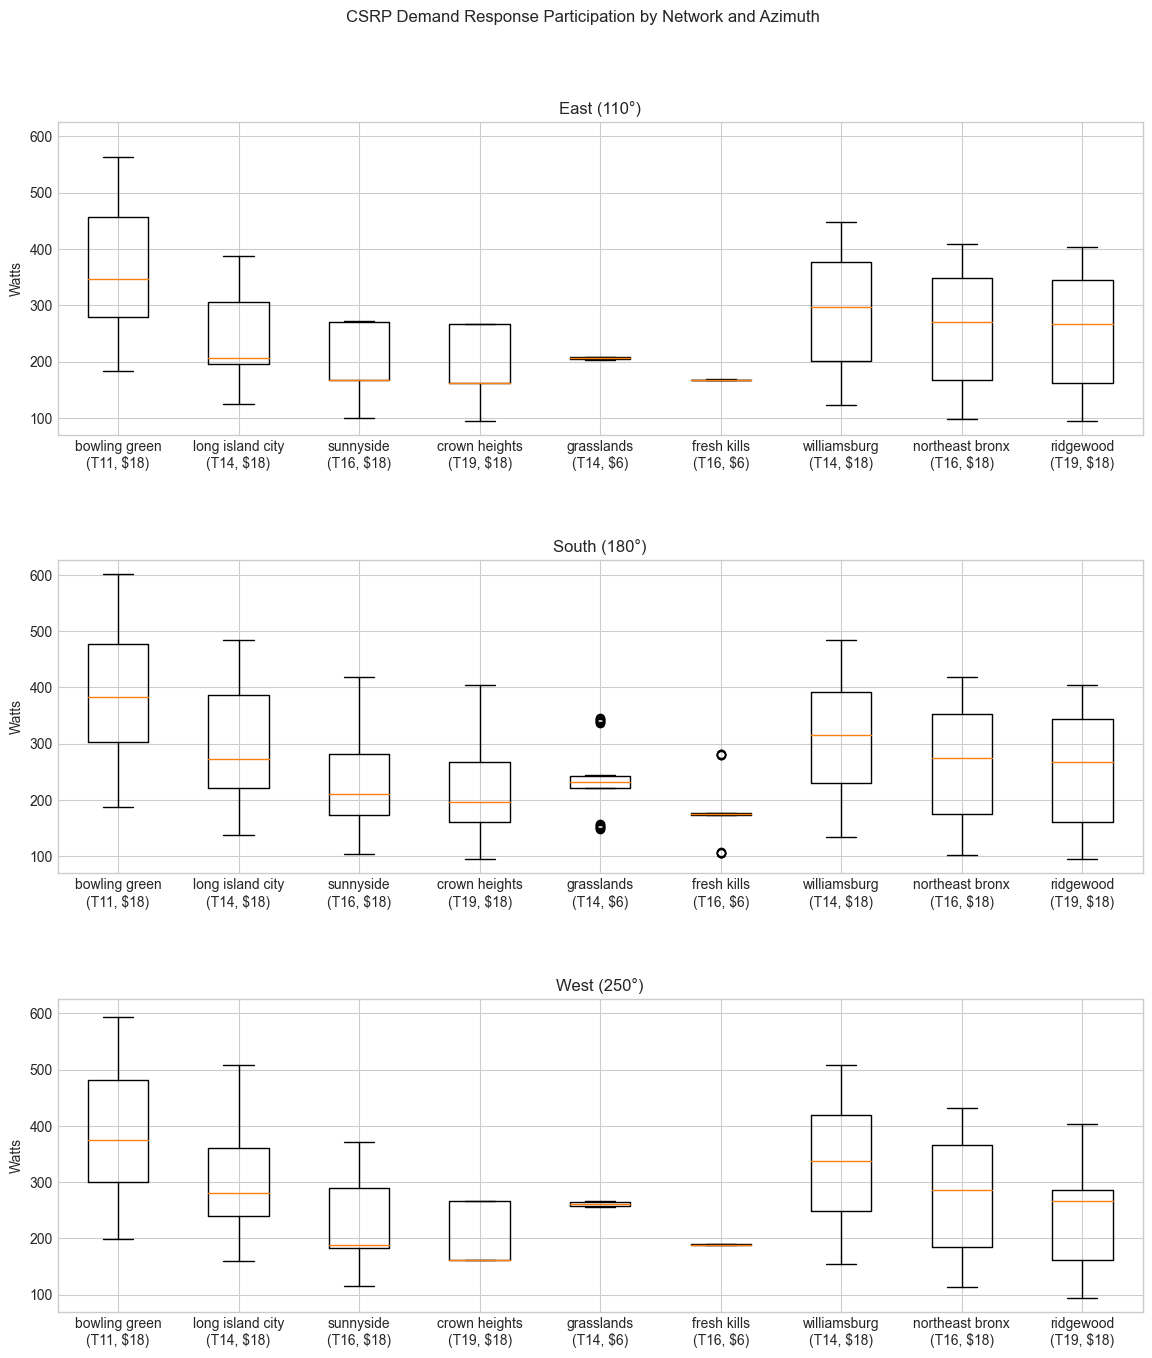

In [83]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getCSRPrate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['avgMAPw_C']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('CSRP Demand Response Participation by Network and Azimuth')
    
plt.show()


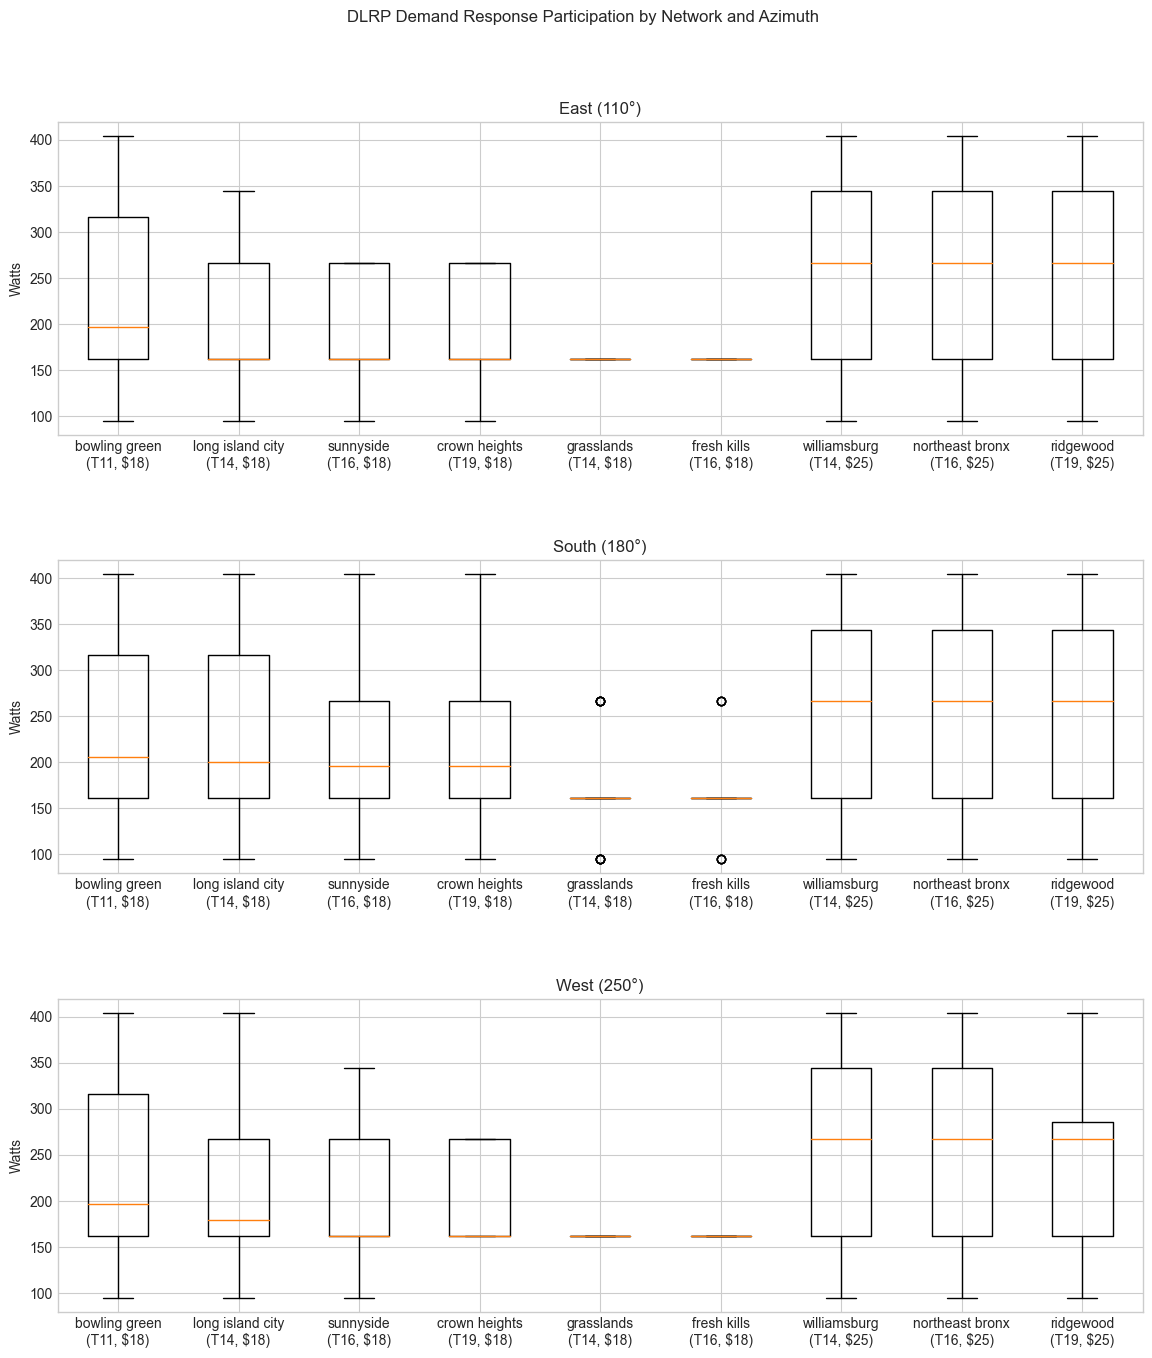

In [84]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getDLRPrate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['avgMAPw_D']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('DLRP Demand Response Participation by Network and Azimuth')
    
plt.show()


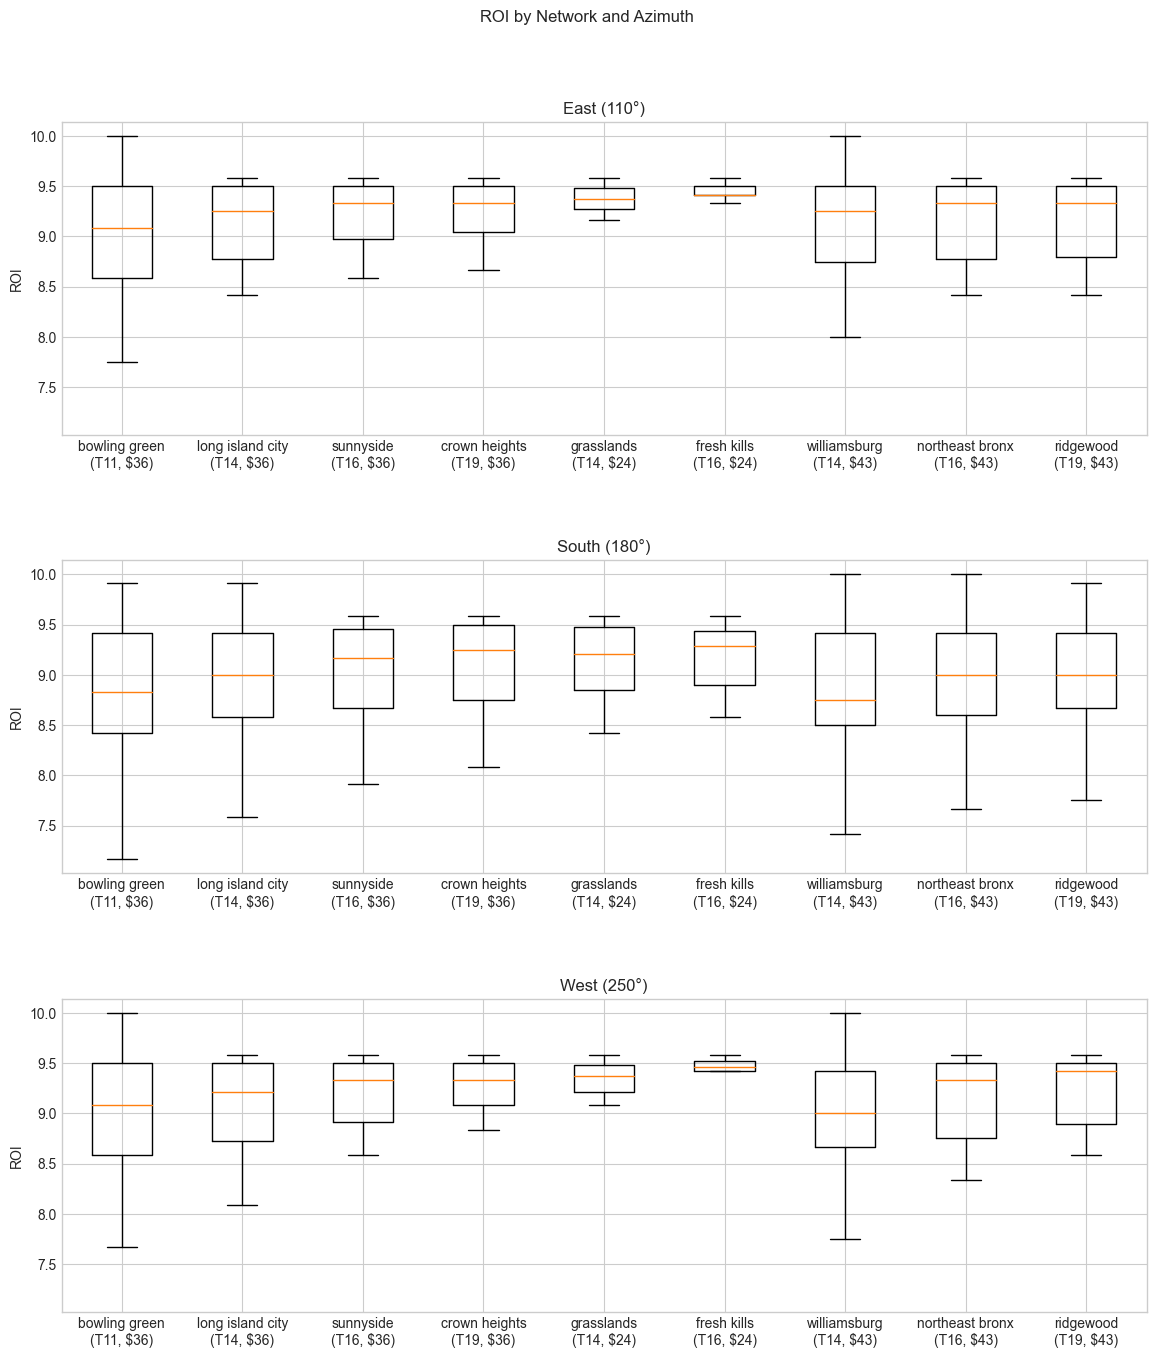

In [85]:
#box plot for ROI

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['realRoi']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('ROI') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('ROI by Network and Azimuth')
    
plt.show()


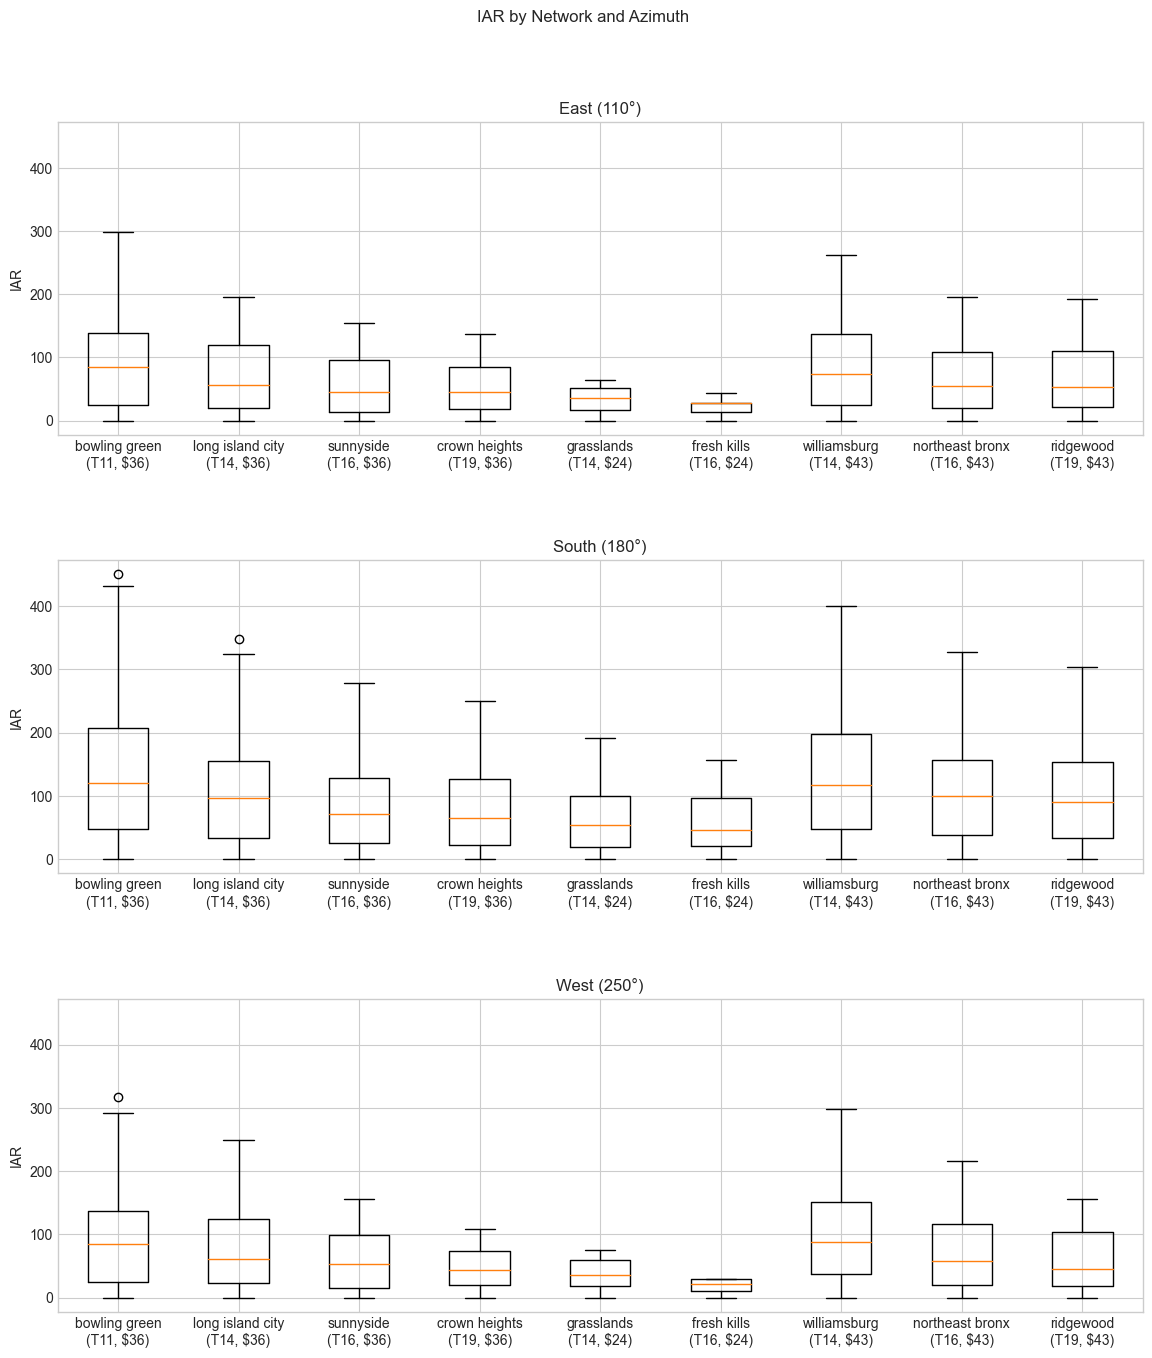

In [86]:
#box plot for IAR

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['incomeAfterRoi']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('IAR') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('IAR by Network and Azimuth')
    
plt.show()


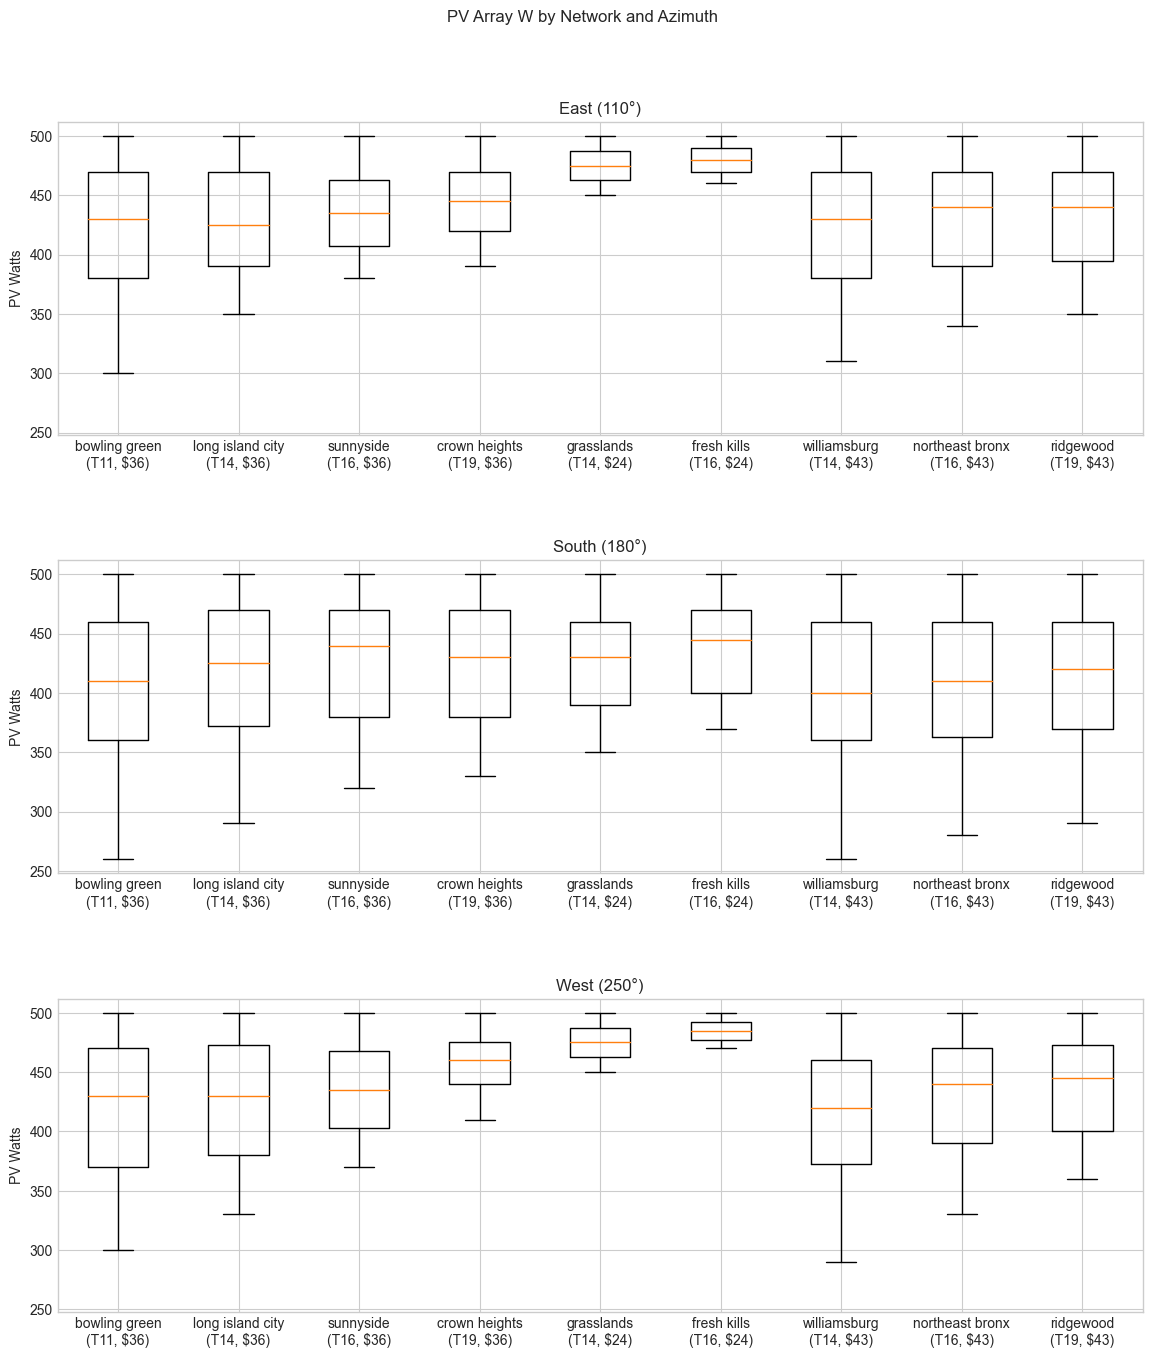

In [101]:
#box plot for IAR

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['pvW']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('PV Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('PV Array W by Network and Azimuth')
    
plt.show()

<AxesSubplot:title={'center':'Max Auto Participation CSRP'}, xlabel='avgMAPw_C', ylabel='eventStart'>

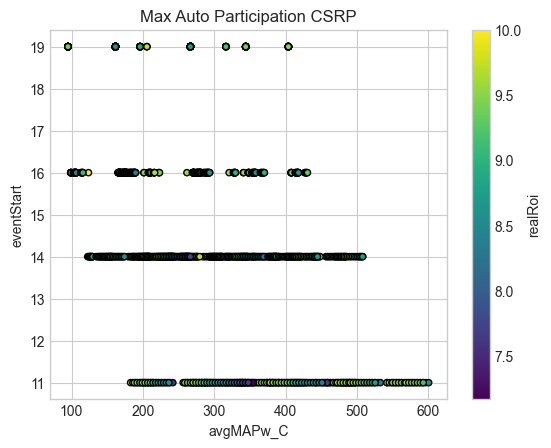

In [87]:
favROI_df_Z.plot(kind = 'scatter', x = 'avgMAPw_C', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto Participation CSRP')


<AxesSubplot:title={'center':'Max Auto Participation DLRP'}, xlabel='avgMAPw_D', ylabel='eventStart'>

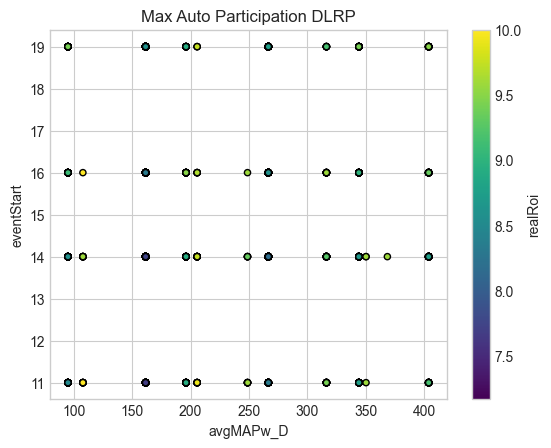

In [88]:
favROI_df_Z.plot(kind = 'scatter', x = 'avgMAPw_D', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto Participation DLRP')


<AxesSubplot:title={'center':'Income After ROI'}, xlabel='incomeAfterRoi', ylabel='eventStart'>

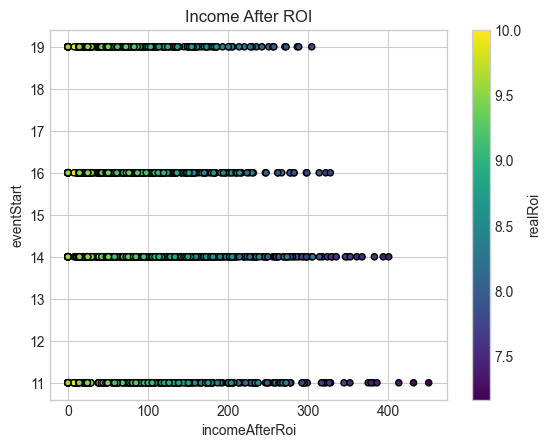

In [89]:
favROI_df_Z.plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Income After ROI')


<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

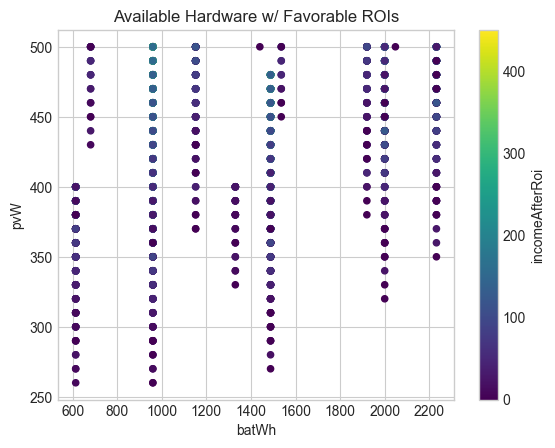

In [90]:
favROI_df_Z.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


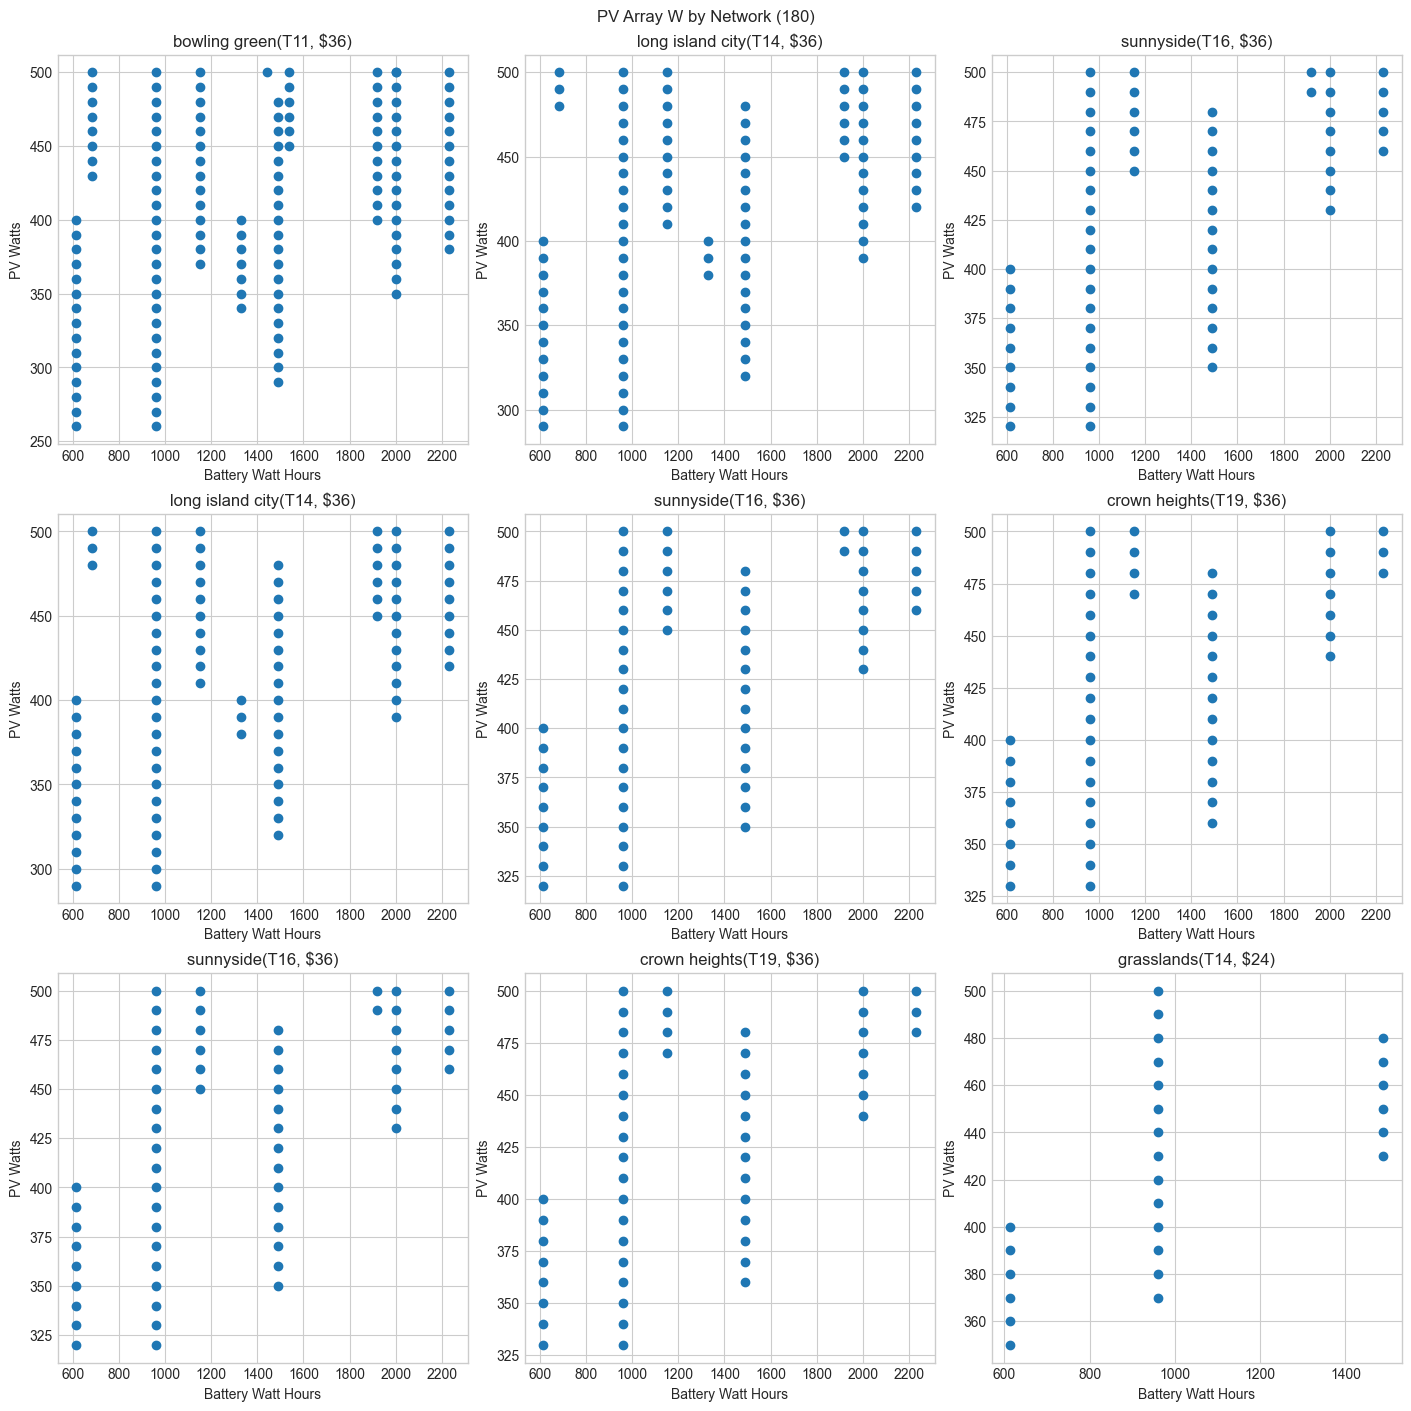

In [122]:
#hardware combos by network

fig, axs = plt.subplots(3,3, figsize=(14, 14), layout="constrained")

azi = 180

hc_df = favROI_df_Z[favROI_df_Z['az'] == azi]

myLabels=[]
for n in myNetworks:
    mN = hc_df[hc_df['network'] == n]
    myLabels.append(n + "(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for x in range(3):
    for y in range(3):
        n = myNetworks[x+y]     
        nhc_df = hc_df[hc_df['network'] == n]

        axs[x,y].scatter(x = nhc_df['batWh'], y = nhc_df['pvW'])
        axs[x,y].set_title(myLabels[x+y])
        axs[x,y].set_ylabel('PV Watts') 
        axs[x,y].set_xlabel('Battery Watt Hours') 

# fig.subplots_adjust(bottom=0.05, top=0.9,
#                     hspace=0.4, wspace=0.3)
fig.suptitle('PV Array W by Network (180)')
    
plt.show()

<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs & high IAR'}, xlabel='batWh', ylabel='pvW'>

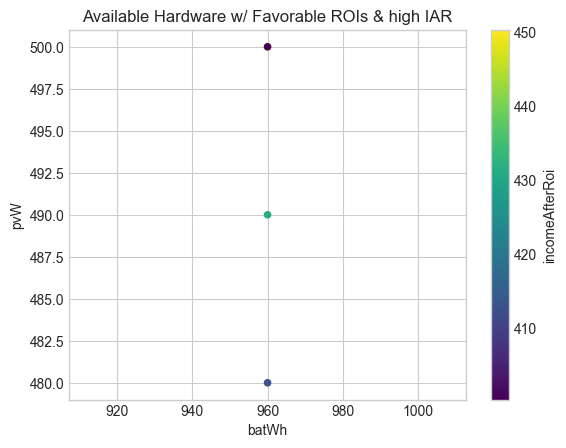

In [91]:
favROI_df_Z[favROI_df_Z['incomeAfterRoi']>=400].plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs & high IAR')


<AxesSubplot:title={'center':'Relationship between IAR and CSRP Participation (Event Time: 11am)'}, xlabel='incomeAfterRoi', ylabel='avgMAPw_C'>

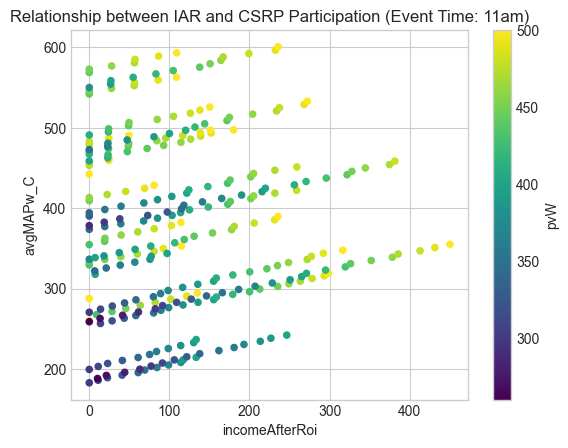

In [92]:
favROI_df_Z[favROI_df_Z['eventStart']==11].plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'avgMAPw_C', c='pvW',colormap='viridis', title='Relationship between IAR and CSRP Participation (Event Time: 11am)')


<AxesSubplot:title={'center':'Relationship between IAR and DLRP Participation (Event Time: 11am)'}, xlabel='incomeAfterRoi', ylabel='avgMAPw_D'>

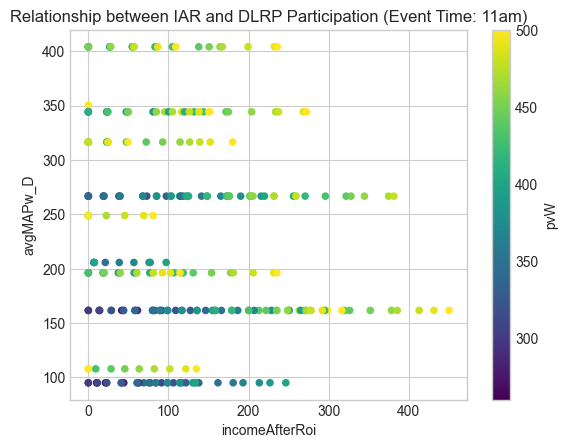

In [93]:
favROI_df_Z[favROI_df_Z['eventStart']==11].plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'avgMAPw_D', c='pvW',colormap='viridis', title='Relationship between IAR and DLRP Participation (Event Time: 11am)')


In [94]:
highParticipation_df = favROI_df_Z[favROI_df_Z['avgMAPw_C']>=400]
highParticipation_df.shape[0]

282

<AxesSubplot:title={'center':'Max Auto CSRP Participation > 400W'}, xlabel='avgMAPw', ylabel='eventStart'>

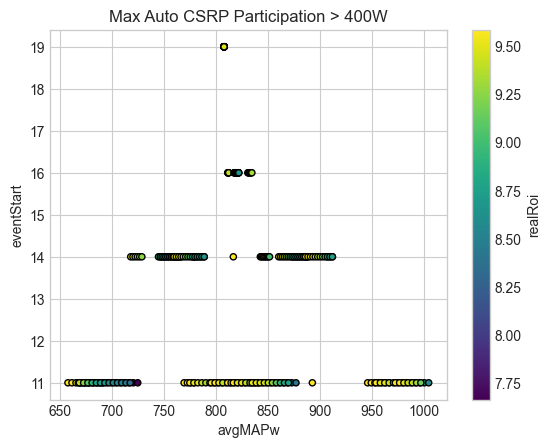

In [95]:
highParticipation_df.plot(kind = 'scatter', x = 'avgMAPw', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto CSRP Participation > 400W')


<AxesSubplot:title={'center':'Available Hardware w/ CSRP Impact > 400W'}, xlabel='batWh', ylabel='pvW'>

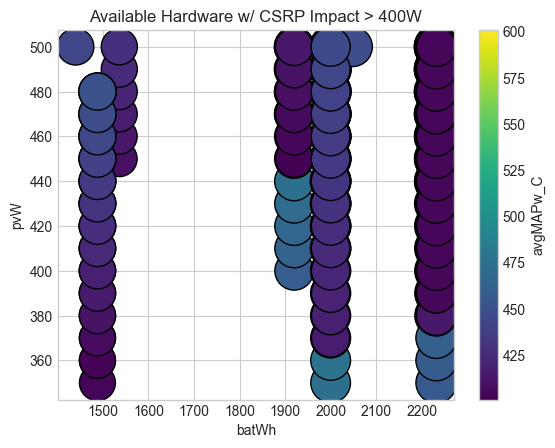

In [96]:
highParticipation_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='avgMAPw_C',s='avgMAPw',edgecolor='black',colormap='viridis', title='Available Hardware w/ CSRP Impact > 400W')


## Impact of Immediate Events

In [123]:
snapShot(favROI_df_Z)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.667265768324594
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.603568535056759
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 7.166666666666667yrs
Mean ROI: 9.028382053025153
Median ROI: 9.166666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $450.2616886342059 ($46.95586181471005/per year for 9.58904109589041 years)
Mean IROI: 95.55702409368867
Median IROI: 78.44456713205986
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $46.95586181471005
Mean IAR Split: 9.959824339786902
Median IAR Split: 8.180647715200529
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[260, 614.0]', '[260, 960.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2048.0]', '[500, 1920.0]', '[500, 1440.0]', '[500, 1536.0]', '[500, 680.96]', '[500, 2000.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 2232.0]'}
mean PV: 420.46227056424203
m

In [124]:
snapShot(favROI_df_O)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.66845344451062
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.603789103491305
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 7.166666666666667yrs
Mean ROI: 9.025132275132275
Median ROI: 9.166666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $450.2616886342059 ($46.95586181471005/per year for 9.58904109589041 years)
Mean IROI: 95.92738816114966
Median IROI: 78.07521213901623
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $46.95586181471005
Mean IAR Split: 9.998365909442896
Median IAR Split: 8.142129265925979
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[260, 614.0]', '[260, 960.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2048.0]', '[500, 1920.0]', '[500, 1440.0]', '[500, 1536.0]', '[500, 680.96]', '[500, 2000.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 2232.0]'}
mean PV: 421.15942028985506
me

In [125]:
snapShot(favROI_df_F)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.672910259994408
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.604616797795437
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 7.166666666666667yrs
Mean ROI: 9.012572886297376
Median ROI: 9.166666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $450.2616886342059 ($46.95586181471005/per year for 9.58904109589041 years)
Mean IROI: 97.35057019573159
Median IROI: 79.22341663758323
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $46.95586181471005
Mean IAR Split: 10.146475336265821
Median IAR Split: 8.23897602581104
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[260, 614.0]', '[260, 960.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2048.0]', '[500, 1920.0]', '[500, 1440.0]', '[500, 1536.0]', '[500, 680.96]', '[500, 2000.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 2232.0]'}
mean PV: 422.0408163265306
me

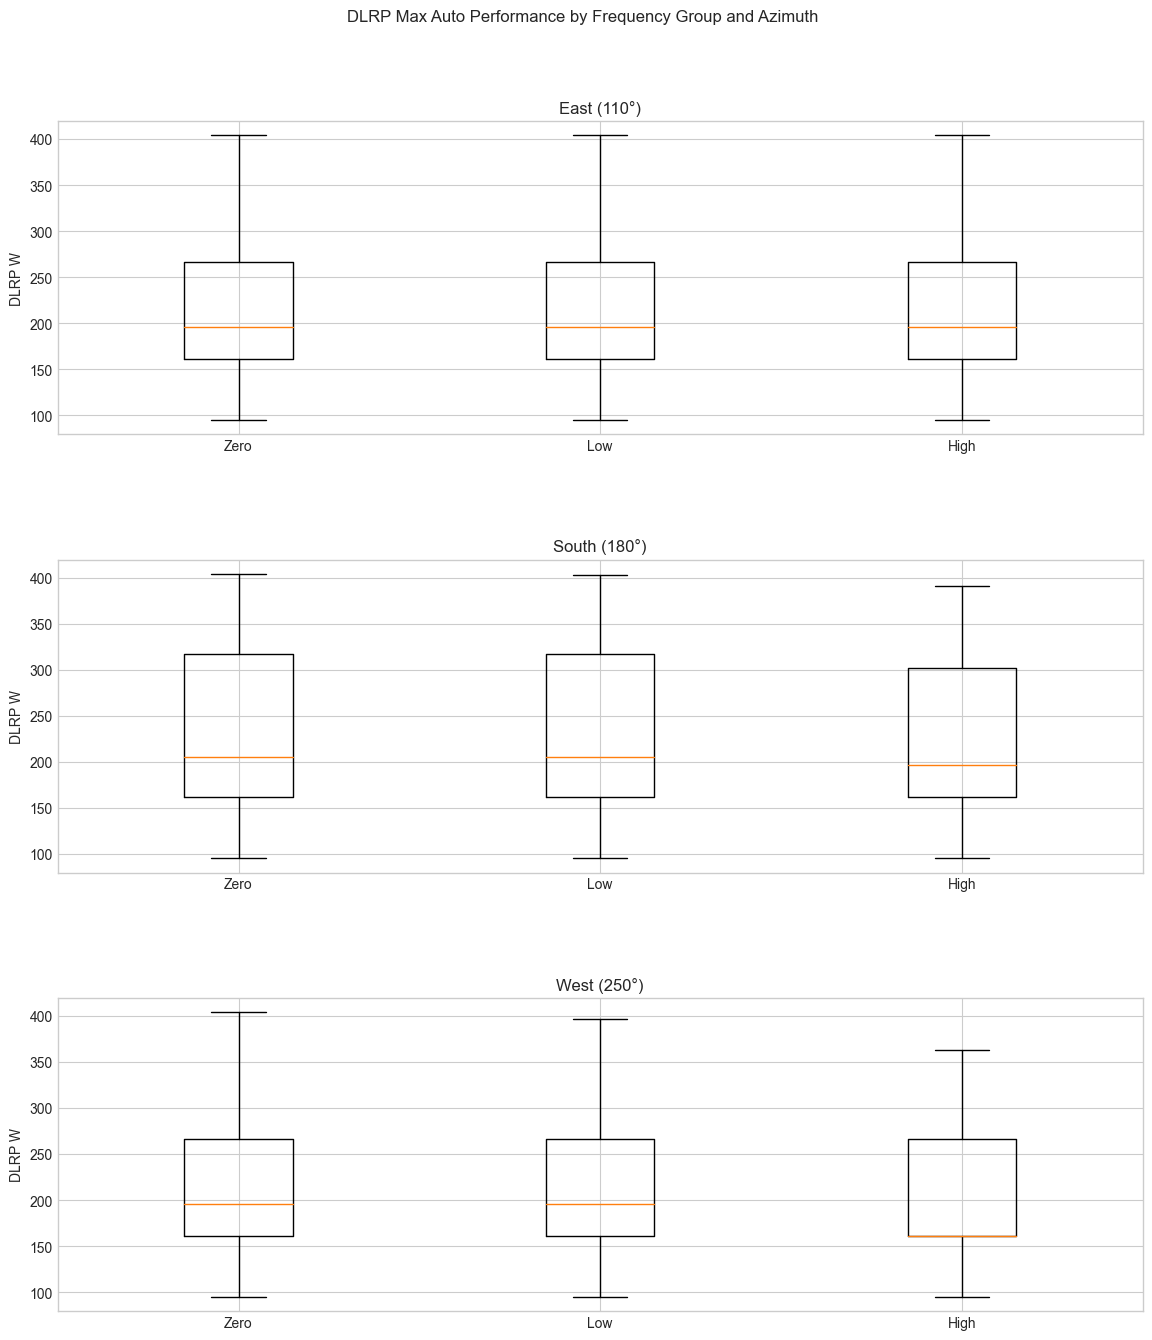

In [97]:
#box plot for IAR

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
# myLabels=[]
# for n in myNetworks:
#     mN = favROI_df_Z[favROI_df_Z['network'] == n]
#     myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    boxPlotData = []

    boxPlotData.append(list(favROI_df_Z[favROI_df_Z['az'] == azi[a]]['avgMAPw_D']))
    boxPlotData.append(list(favROI_df_O[favROI_df_O['az'] == azi[a]]['avgMAPw_D']))
    boxPlotData.append(list(favROI_df_F[favROI_df_F['az'] == azi[a]]['avgMAPw_D']))

#     for n in myNetworks:
#         bP = bPD[bPD['network'] == n]
#         boxPlotData.append(list(bP['incomeAfterRoi']))

    axs[a].boxplot(boxPlotData, labels=['Zero','Low','High'])
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('DLRP W') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('DLRP Max Auto Performance by Frequency Group and Azimuth')
    
plt.show()

## Loads


### Typical Appliances

#### Fixed
* Refrigerator

#### Behavior Dependent
Note that baselines are determined by X, so random loads that aren't used at generally the same time each day wouldn't be considered.
* AC
* Fan
* Lamp
* Overhead lights
* Computer
* Electric Stove
* Convection stove

### 4 hour rates

In [98]:
favROI_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batWh', 'batWhAC', 'effEff',
       'gridChargeTime', 'dischargeRateW', 'capex', 'dollarPerBatkWh',
       'annualPVkWhDC_degraded', 'annualPVkWhAC_degraded', 'avoidedGridCosts',
       'immediateEventAmt', 'maxAutoParticipationMonthlyW_C',
       'maxAutoParticipationMonthlyW_D', 'maxAutoParticipationW_C',
       'maxAutoParticipationW_D', 'avgMAPw_C', 'avgMAPw_D', 'totalDRratekW',
       'drIncMonthly_C', 'drIncMonthly_D', 'drIncAnnual_C', 'drIncAnnual_D',
       'drPerformanceIncome', 'minDRinc', 'minDRkWperf', 'annualIncome',
       'LCOSS', 'realRoi', 'Cycles', 'lifespan', 'workingLife',
       'profitableYears', 'incomeAfterRoi', 'iarSplit'],
      dtype='object')

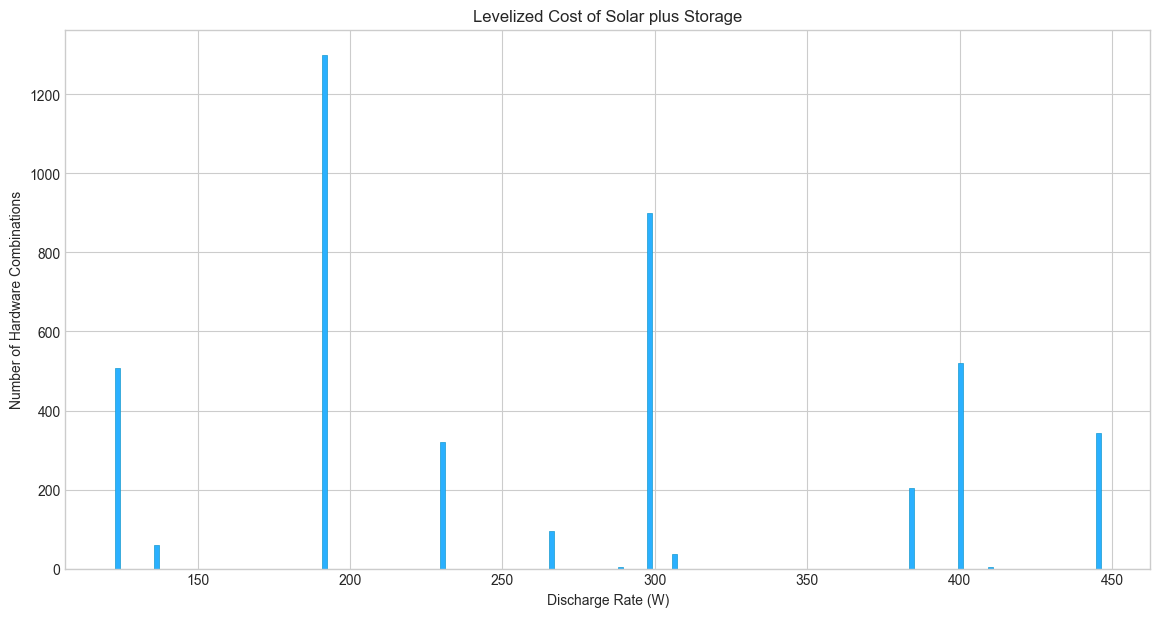

In [99]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['dischargeRateW'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Levelized Cost of Solar plus Storage') 
plt.xlabel('Discharge Rate (W)') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

In [100]:
# Typical refrigerator
# source: https://www.energysage.com/electricity/house-watts/how-many-watts-does-a-refrigerator-use/#:~:text=A%20home%20refrigerator's%20power%20consumption,amps%20and%20about%20120%20volts.
fridgeDutyCycle = .333

fridgeMaxW = 800 * fridgeDutyCycle
fridgeMinW = 300 * fridgeDutyCycle
print('Fridge Watts')
print('Max: ' + str(fridgeMaxW) + 'W (' + str(fridgeMaxW * 24) + ' Wh/day)')
print('Min: ' + str(fridgeMinW) + 'W (' + str(fridgeMinW * 24) + ' Wh/day)')


Fridge Watts
Max: 266.40000000000003W (6393.6 Wh/day)
Min: 99.9W (2397.6000000000004 Wh/day)


## Final Analysis

Compare to Nest thermostat